# House Prices dataset

In [1]:
# Importación de bibliotecas estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import math
import scipy.stats as stats

In [2]:
import optuna
from optuna.pruners import HyperbandPruner

In [3]:
import lightgbm as lgb

In [4]:
import folium
import webbrowser
from IPython.display import display, IFrame

In [5]:
# Importaciones de sklearn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, roc_curve, confusion_matrix, classification_report, mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
# Importaciones de Feature-engine
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from feature_engine.selection import DropFeatures

In [7]:
# Importaciones de Phik
from phik import phik_matrix

In [8]:
# Estadísticas adicionales
from scipy.stats import chi2_contingency

## Cargo los datos

In [9]:
# load dataset
raw_data = pd.read_csv('../House Prices/Datasets/houseprice.csv', index_col= 'id')

In [10]:
raw_data.index.name = None

Este dataset proviene de las ventas de viviendas en el condado de King, en el estado de Washington (EE. UU.) para análisis de precios de viviendas y predicción de precios de casas en problemas de regresión.

Descripción de las columnas:
-    date: Fecha en que se vendió la propiedad (en formato YYYYMMDD).
-    price: Precio de la vivienda (target variable).
-    bedrooms: Número de dormitorios.
-    bathrooms: Número de baños.
-    sqft_living: Metros cuadrados del área habitable.
-    sqft_lot: Tamaño del lote (en pies cuadrados).
-    floors: Número de pisos en la propiedad.
-    waterfront: Si la propiedad tiene acceso a la orilla del agua (1 = sí, 0 = no).
-    view: Valoración de la vista de la propiedad (0 a 4, siendo 4 la mejor vista).
-    condition: Estado de la vivienda (1 a 5, donde 5 es la mejor condición).
-    grade: Calificación general de la casa (de 1 a 13).
-    sqft_above: Área habitable sobre el nivel del suelo.
-    sqft_basement: Área de sótano.
-    yr_built: Año de construcción.
-    yr_renovated: Año de renovación (si corresponde).
-    zipcode: Código postal.
-    lat y long: Coordenadas geográficas (latitud y longitud).
-    sqft_living15 y sqft_lot15: Áreas de la vivienda y lote para las 15 casas más cercanas.

## Analisis preliminar

### Analiso que los datos se hayan importado correctamente

In [11]:
df = raw_data.copy()

In [12]:
df.shape

(21597, 20)

In [13]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Verifico la forma en que se importaron los tipos de datos

In [14]:
df.dtypes

date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### Analisis estadistico preliminar de las caracteristicas numéricas

In [15]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,7.657915,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,1.173200,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Chequeo de valores nulos

In [16]:
i = 0
for col in list(df.columns):
    if df[col].isnull().mean() > 0:
        print(col, df[col].isnull().mean())
        i +=1
if i == 0:
    print('No hay caracteristicas con valores nulos')

No hay caracteristicas con valores nulos


### Chequeo de filas duplicadas

In [17]:
duplicated_rows = df.duplicated().sum()
print("Filas duplicadas encontradas:", duplicated_rows)

Filas duplicadas encontradas: 0


### Chequeo indices duplicados

In [18]:
# Verificar qué filas tienen índices duplicados
duplicated_indices = df[df.index.duplicated(keep=False)]
duplicated_indices_sorted = duplicated_indices.sort_index()
duplicated_indices_sorted

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1000102,4/22/2015,300000.0,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,47.3262,-122.214,2060,7316
1000102,9/16/2014,280000.0,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,47.3262,-122.214,2060,7316
7200179,10/16/2014,150000.0,2,1.00,840,12750,1.0,0,0,3,6,840,0,1925,0,98055,47.4840,-122.211,1480,6969
7200179,4/24/2015,175000.0,2,1.00,840,12750,1.0,0,0,3,6,840,0,1925,0,98055,47.4840,-122.211,1480,6969
109200390,10/20/2014,250000.0,3,1.75,1480,3900,1.0,0,0,4,7,1480,0,1980,0,98023,47.2977,-122.367,1830,6956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9828200460,6/27/2014,260000.0,2,1.00,700,4800,1.0,0,0,3,7,700,0,1922,0,98122,47.6147,-122.300,1440,4800
9834200305,2/10/2015,615000.0,3,1.00,1790,3876,1.5,0,0,5,7,1090,700,1904,0,98144,47.5750,-122.288,1360,4080
9834200305,7/16/2014,350000.0,3,1.00,1790,3876,1.5,0,0,5,7,1090,700,1904,0,98144,47.5750,-122.288,1360,4080
9834200885,7/17/2014,360000.0,4,2.50,2080,4080,1.0,0,0,5,7,1040,1040,1962,0,98144,47.5720,-122.290,1340,4080


In [19]:
# Una casa se pudo haber vendido dos veces, entonces hago que el índice actual en una columna llamada 'id'
df = df.reset_index()
df.rename(columns={'index': 'id'}, inplace=True)
df.head(4)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000


### Chequeo preliminar de caracteristicas categoricas

In [20]:
# Para saber cuales son las variables dicretas con menos de 101 clases
discrete = []

for var in list(df.columns):
    if len(df[var].unique()) < 101:
        print(var, ' values: ', df[var].nunique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

bedrooms  values:  12
bathrooms  values:  29
floors  values:  6
waterfront  values:  2
view  values:  5
condition  values:  5
grade  values:  11
yr_renovated  values:  70
zipcode  values:  70

There are 9 discrete variables


In [21]:
cat_cols = df.select_dtypes(include=['category']).columns
discrete = ['waterfront', 'view', 'floors', 'bedrooms', 'bathrooms', 'condition', 'grade', 'zipcode', 'yr_built', 'yr_renovated', 'bathrooms']

# Concatenar las listas
cat_cols = list(cat_cols) + discrete
num_cols = list(set(df.select_dtypes(include=['int', 'float']).columns) - set(cat_cols) - set(['lat', 'long']))

### Analisis preliminar de la relacion entre las clases de las variables preliminares categoricas con el precio de venta medio

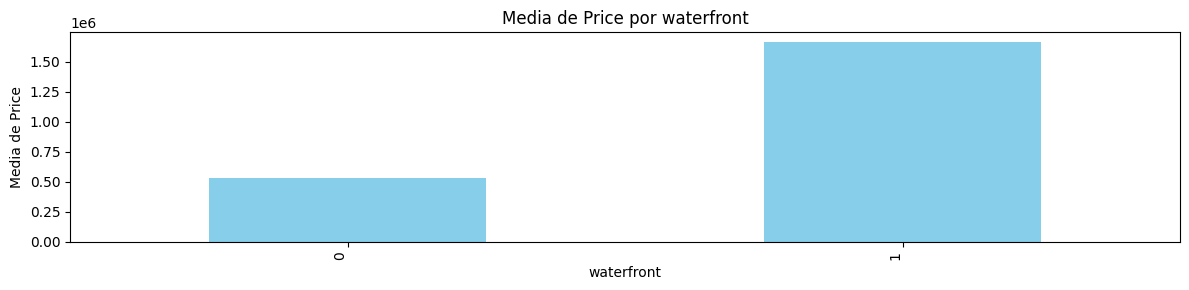

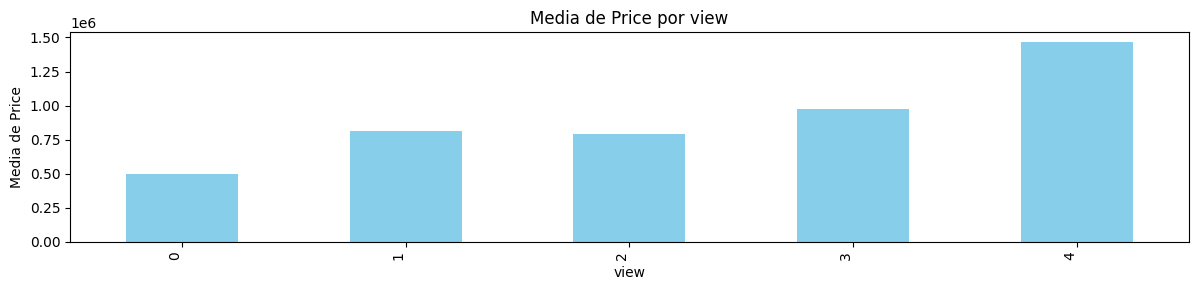

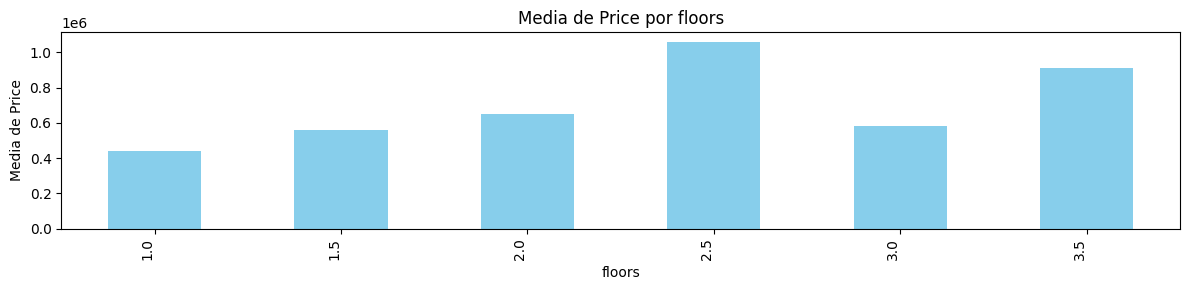

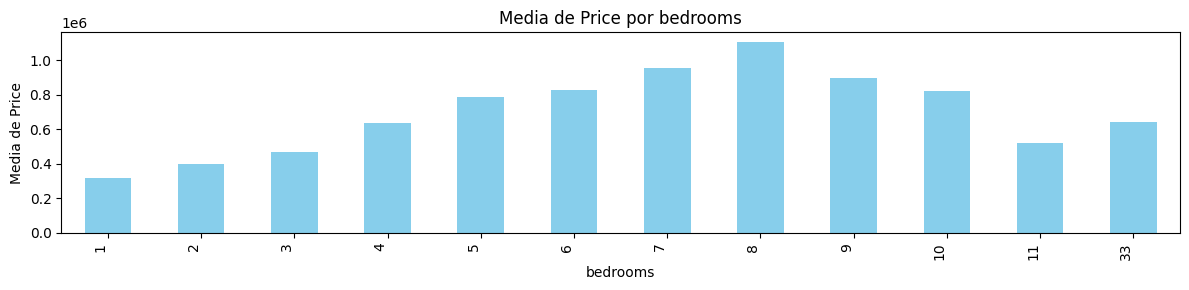

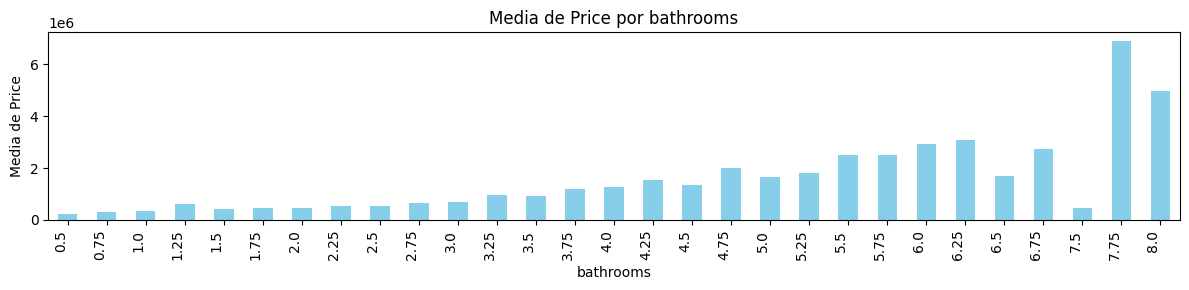

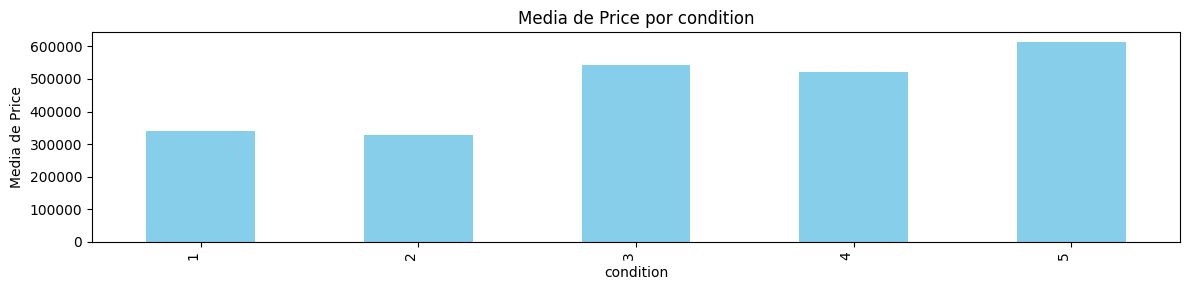

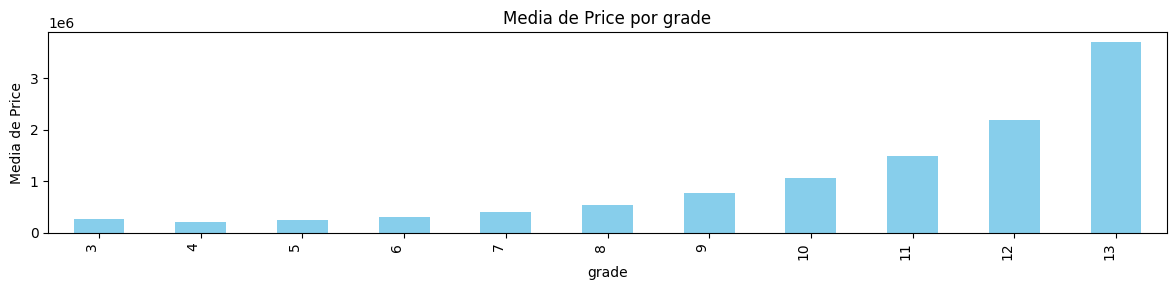

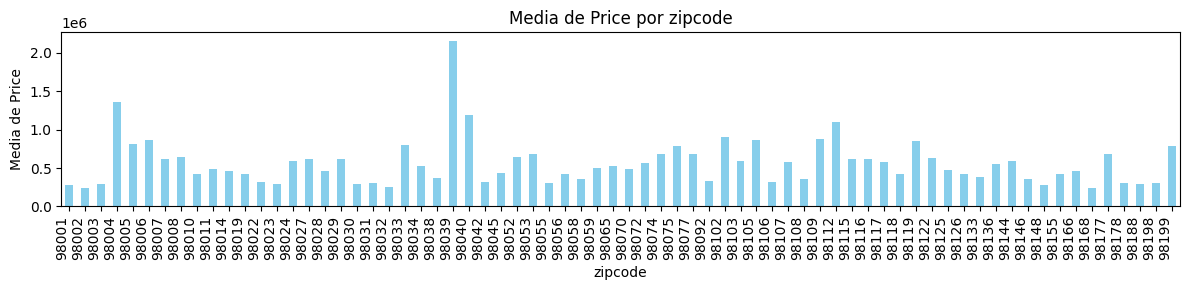

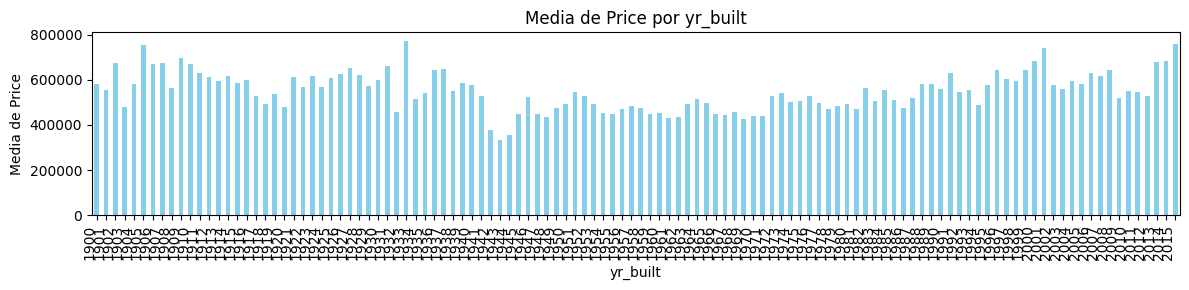

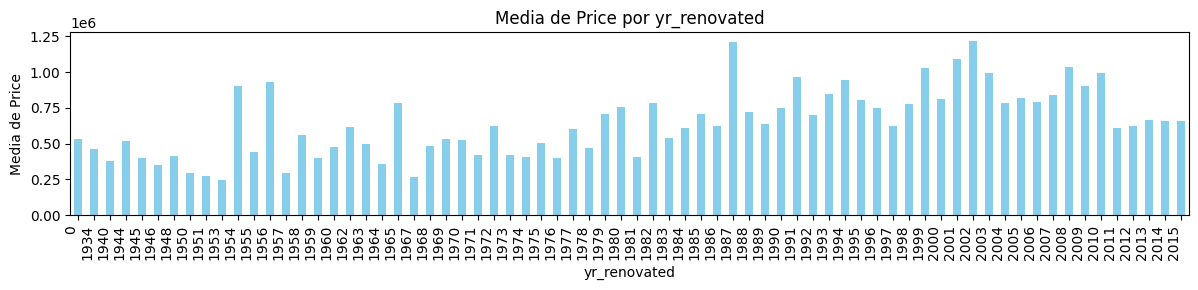

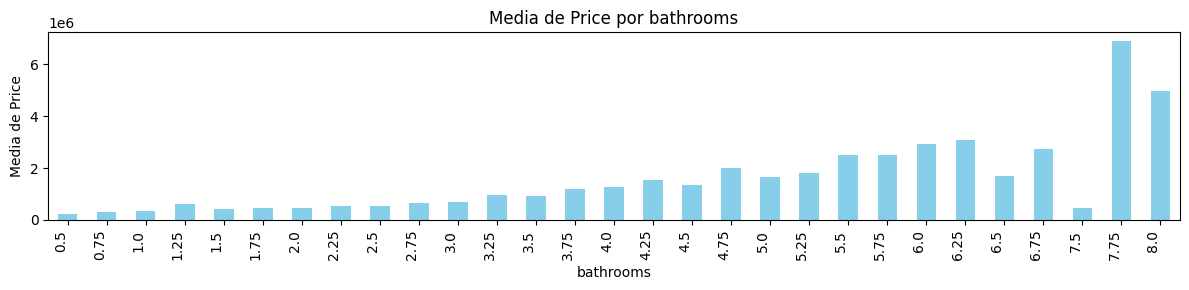

In [22]:
for var in cat_cols:
    plt.figure(figsize=(12, 3))
    # Calcular la media de 'price' por cada categoría de 'var'
    mean_price = df.groupby(var)['price'].mean()

    # Graficar la media de 'price' por cada categoría de 'var'
    mean_price.plot(kind='bar', color='skyblue')

    # Personalizar el gráfico
    plt.title(f'Media de Price por {var}')
    plt.xlabel(var)
    plt.ylabel('Media de Price')
    plt.xticks(rotation=90, ha="right")  # Rotar etiquetas si es necesario
    plt.tight_layout()  # Ajustar el layout para evitar superposición
    plt.show()

### Analisis preliminar de las distribuciones de variables continuas

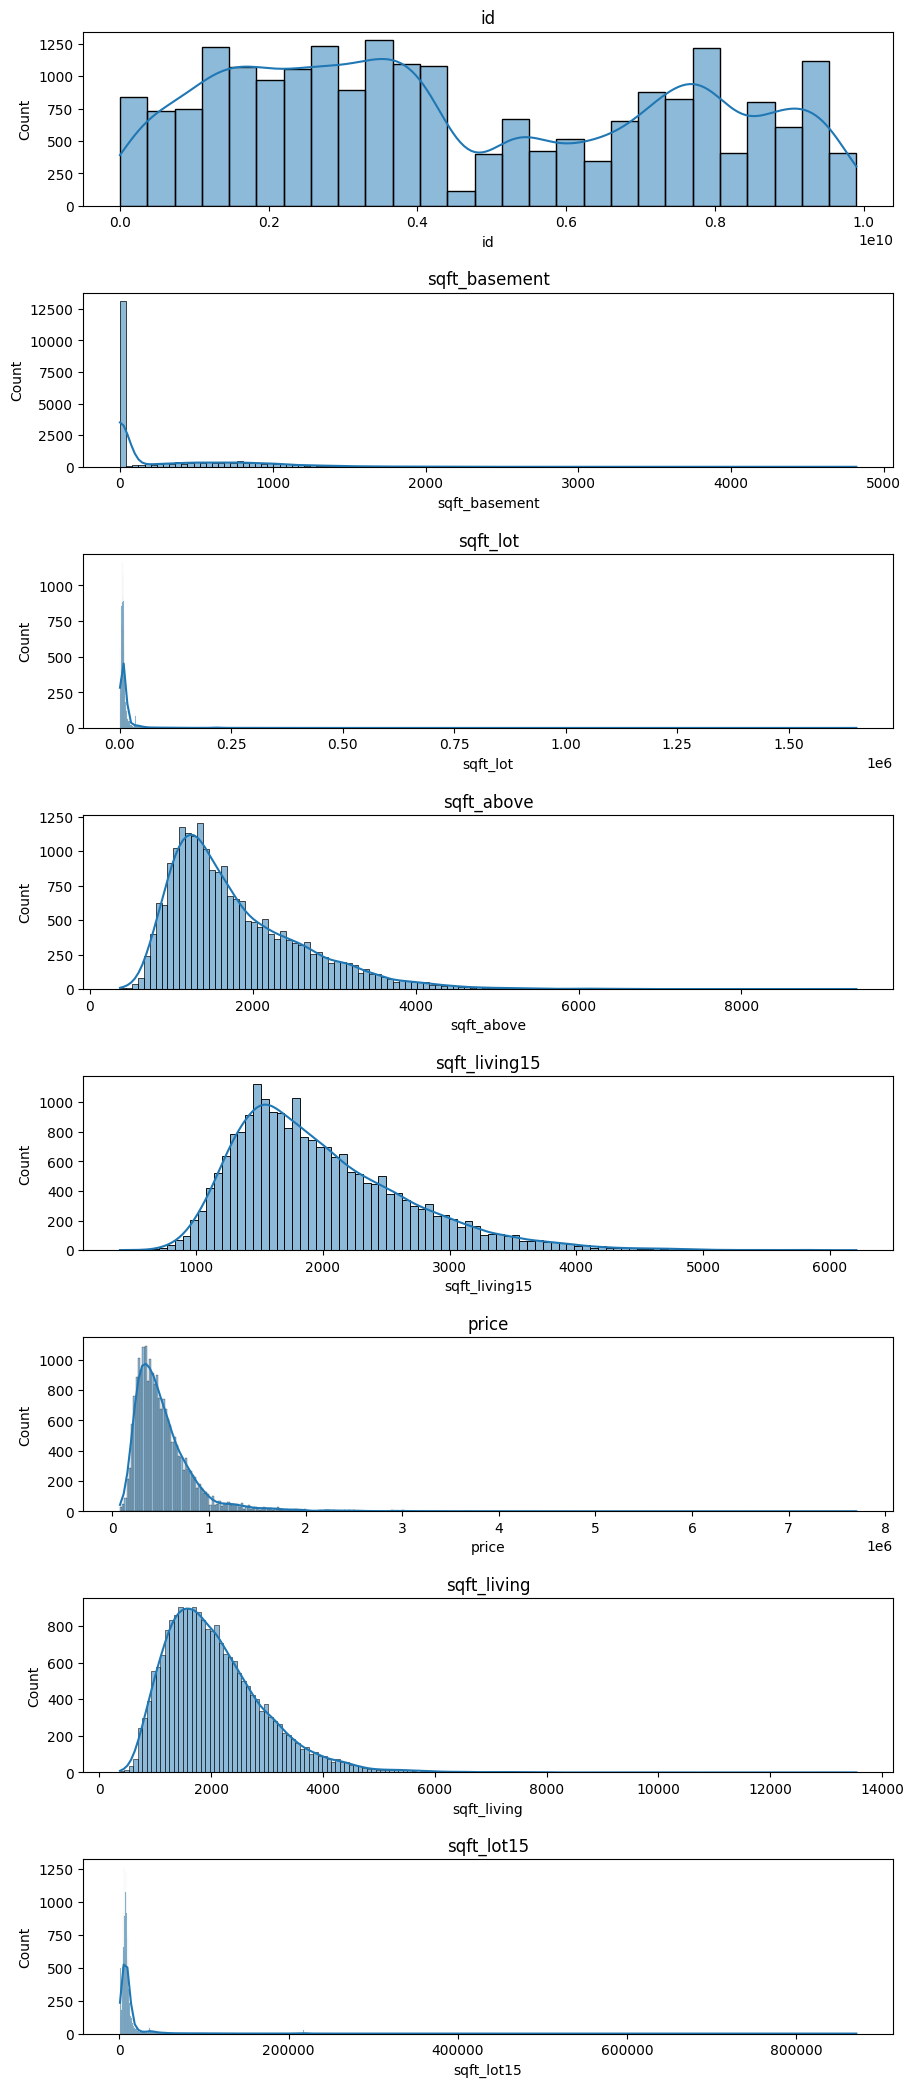

In [23]:
num_vars = len(num_cols)
num_cols_subplot = 1  # Usar una columna
num_rows_subplot = math.ceil(num_vars / num_cols_subplot)

# Aumentar el tamaño total de la figura
plt.figure(figsize=(12, 5 + (num_rows_subplot - 1) * 3))  # Ajusta el multiplicador según sea necesario

for i, var in enumerate(num_cols):
    plt.subplot(num_rows_subplot, num_cols_subplot, i + 1)
    sns.histplot(data=df, x=var, stat="count", kde=True)
    plt.title(var)  # Añadir título a cada subplot

# Ajustar espacio entre filas
plt.subplots_adjust(hspace=0.5, right=0.8)  # Dejar espacio a la derecha para la leyenda

plt.show()

### Analisis preliminar de correlaciones

<Figure size 640x480 with 0 Axes>

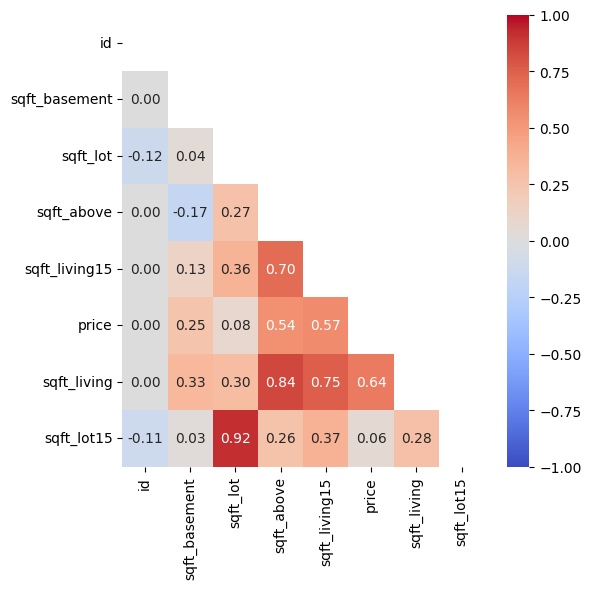

In [24]:
# Ajustar el diseño
plt.tight_layout()
plt.show()

# Calcular la matriz de correlación
corr = df[num_cols].corr(method='spearman').round(2)

# Crear la máscara para el triángulo superior
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Configurar el tamaño de la figura
plt.figure(figsize=(6, 6))

# Heatmap con tamaño de letras ajustado
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, vmin=-1, vmax=1, center=0,
            annot_kws={'size': 10},  # Reduce el tamaño de las anotaciones
           )  

# Ajustar el diseño
plt.tight_layout()
plt.show()

interval columns not set, guessing: ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


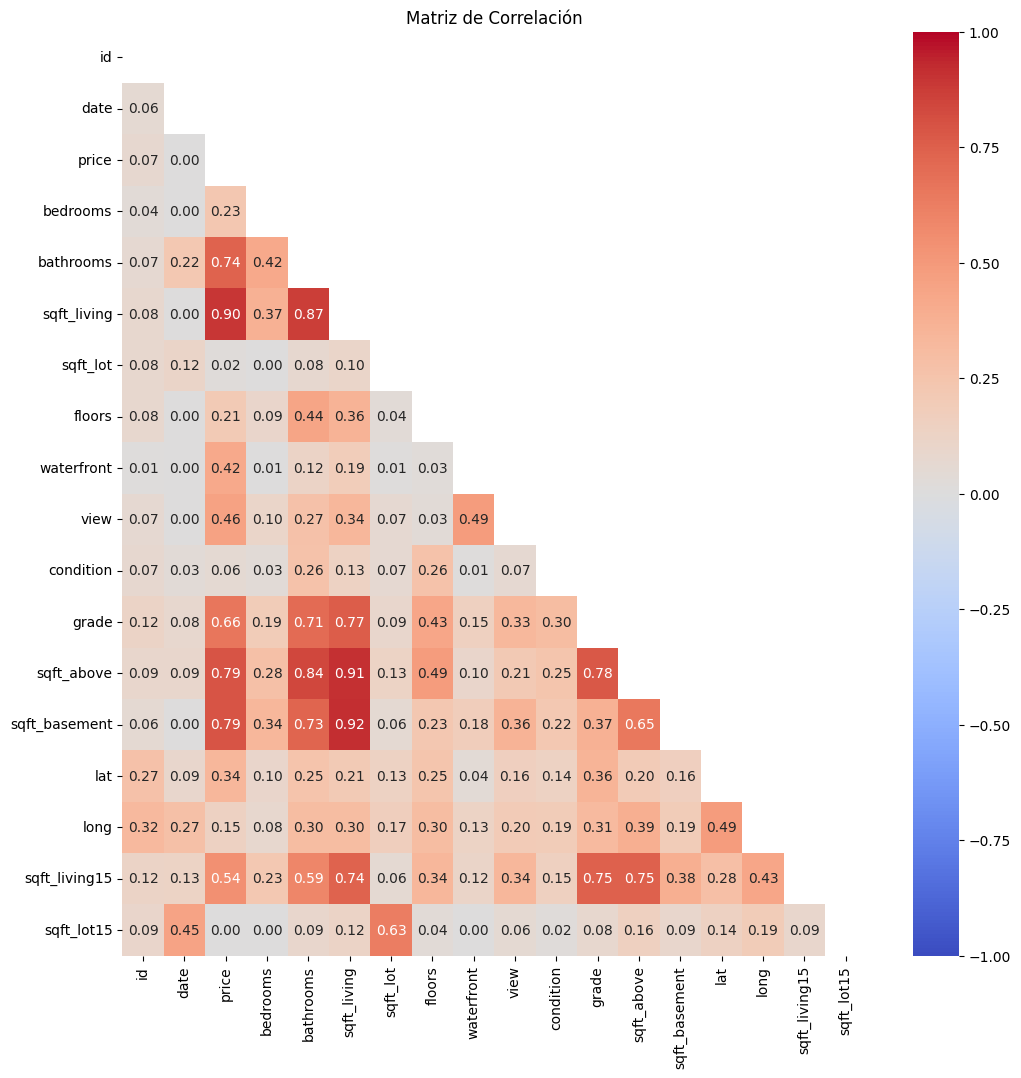

In [25]:
# Calcular la matriz de correlación usando phik, excluyendo 'ScheduledDay'
corr_matrix = df.drop(columns=['zipcode', 'yr_built', 'yr_renovated']).phik_matrix()

# Crear una máscara para el triángulo superior
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Graficar la matriz de correlación
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

## Separo el conjunto de datos en los conjuntos de entrenamiento y prueba

In [26]:
X = df.drop(columns = "price")
y = df.loc[:, ['price']]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((17277, 20), (4320, 20))

In [28]:
y_train.shape, y_test.shape

((17277, 1), (4320, 1))

## Ingenieria de datos

### Convertir la columna 'date' a tipo datetime

In [29]:
# Función para convertir a datetime
def convert_to_datetime(X, column_names):
    for column in column_names:
        if column in X.columns:  # Verificar si la columna existe
            # Especificamos el formato mm/dd/yyyy al usar 'format'
            X[column] = pd.to_datetime(X[column], format='%m/%d/%Y')
        else:
            print(f"Columna {column} no encontrada en el DataFrame.")
    return X

In [30]:
X_train = convert_to_datetime(X_train, ['date'])
X_test = convert_to_datetime(X_test, ['date'])

In [31]:
X_train['date'].dtypes, X_test['date'].dtypes

(dtype('<M8[ns]'), dtype('<M8[ns]'))

In [32]:
X_train['date']

6243    2014-12-22
8986    2015-05-12
9419    2014-12-29
10155   2015-03-21
10436   2014-07-01
           ...    
11964   2014-09-15
21575   2014-10-02
5390    2014-07-21
860     2014-06-20
15795   2015-03-25
Name: date, Length: 17277, dtype: datetime64[ns]

In [33]:
# Para el pipeline
convert_to_datetime_transformer = FunctionTransformer(convert_to_datetime, validate=False, kw_args={'column_names': ['date']})

### Crear una variable que indique si la casa ya se ha vendido antes y cuantas veces se vendió

In [34]:
def agregar_venta_num(X):
    X_sorted = X.copy()
    X_sorted = X_sorted.sort_values(by=['id', 'date'])
    X_sorted['venta_num'] = X_sorted.groupby('id').cumcount()

    # Restaurar el orden original según el índice
    X_sorted = X_sorted.loc[X.index]

    return X_sorted

In [35]:
X_train_sorted = agregar_venta_num(X_train)
X_train_sorted.head(4)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,venta_num
6243,9834201100,2014-12-22,4,2.00,1440,4855,2.0,0,0,4,...,1440,0,1972,0,98144,47.5717,-122.287,1300,4080,0
8986,7795810110,2015-05-12,3,1.75,1430,9857,1.0,0,2,4,...,1140,290,1980,0,98045,47.4964,-121.771,1310,9880,0
9419,1853081250,2014-12-29,4,2.75,3120,5000,2.0,0,0,3,...,3120,0,2010,0,98074,47.5940,-122.062,3200,5000,0
10155,2558630350,2015-03-21,4,2.50,2060,6958,1.0,0,0,3,...,1220,840,1974,0,98034,47.7251,-122.168,1760,7350,0


In [36]:
X_train.head(4)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6243,9834201100,2014-12-22,4,2.00,1440,4855,2.0,0,0,4,7,1440,0,1972,0,98144,47.5717,-122.287,1300,4080
8986,7795810110,2015-05-12,3,1.75,1430,9857,1.0,0,2,4,7,1140,290,1980,0,98045,47.4964,-121.771,1310,9880
9419,1853081250,2014-12-29,4,2.75,3120,5000,2.0,0,0,3,9,3120,0,2010,0,98074,47.5940,-122.062,3200,5000
10155,2558630350,2015-03-21,4,2.50,2060,6958,1.0,0,0,3,7,1220,840,1974,0,98034,47.7251,-122.168,1760,7350


In [37]:
X_test_sorted = agregar_venta_num(X_test)

In [38]:
# Para el pipeline
agregar_venta_num_transformer = FunctionTransformer(agregar_venta_num, validate=False)

### Crear una variable que calcule la antiguedad de la casa en años a la fecha de su venta

In [39]:
def elapsed_years(df, var): 
    df_copy = df.copy()
    df_copy['elapsed_years'] = df_copy[var].dt.year - df_copy['yr_built']
    return df_copy

In [40]:
X_train_to_date = elapsed_years(X_train_sorted, 'date')
X_test_to_date = elapsed_years(X_test_sorted, 'date')

In [41]:
X_train_to_date[['date', 'yr_built', 'elapsed_years']]

,date,yr_built,elapsed_years
6243,2014-12-22,1972,42
8986,2015-05-12,1980,35
9419,2014-12-29,2010,4
10155,2015-03-21,1974,41
10436,2014-07-01,1922,92
...,...,...,...
11964,2014-09-15,2004,10
21575,2014-10-02,2014,0
5390,2014-07-21,1976,38
860,2014-06-20,1963,51


In [42]:
# Para el pipeline
elapsed_years_transformer = FunctionTransformer(elapsed_years, validate=False, kw_args={'var': 'date'})

### Crear una variable binaria que tome valor uno si el casa se renovó o no

In [43]:
def renovated(df, var):
    # Crear una nueva columna 'renovated' que toma el valor 1 si la columna 'var' es igual a 0, sino 0
    df_copy = df.copy()
    df_copy['no_renovated'] = np.where(df_copy[var] == 0, 1, 0)
    return df_copy

In [44]:
X_train_to_date_1 = renovated(X_train_to_date, 'yr_renovated')
X_test_to_date_1 = renovated(X_test_to_date, 'yr_renovated')

In [45]:
X_train_to_date_1[['yr_renovated', 'no_renovated']].head(10)

,yr_renovated,no_renovated
6243,0,1
8986,0,1
9419,0,1
10155,0,1
10436,0,1
13701,0,1
7944,0,1
15141,1989,0
5554,0,1
2154,1948,0


In [46]:
# Para el pipeline
renovated_transformer = FunctionTransformer(renovated, validate=False, kw_args={'var': 'yr_renovated'})

### Crear una variable que calcule cuanto tiempo paso en años desde la renovación de la casa al año de la venta

In [47]:
def time_since_renovation(df):
    df_copy = df.copy()
    
    # Verificar primero si 'yr_renovated' es 0
    df_copy['years_since_renovation'] = np.where(
        df_copy['yr_renovated'] == 0,  # Si 'yr_renovated' es 0
        0,  # Asignar 0
        np.where(
            df_copy['date'].dt.year < df_copy['yr_renovated'],  # Si 'date' es menor que 'yr_renovated'
            0,  # Asignar 0
            df_copy['date'].dt.year - df_copy['yr_renovated']  # Si no, calcular la diferencia
        )
    )
    
    return df_copy

In [48]:
X_train_to_date_2 = time_since_renovation(X_train_to_date_1)
X_test_to_date_2 = time_since_renovation(X_test_to_date_1)

In [49]:
X_train_to_date_2[['date', 'yr_renovated', 'no_renovated', 'years_since_renovation']].head(10)

,date,yr_renovated,no_renovated,years_since_renovation
6243,2014-12-22,0,1,0
8986,2015-05-12,0,1,0
9419,2014-12-29,0,1,0
10155,2015-03-21,0,1,0
10436,2014-07-01,0,1,0
13701,2014-10-20,0,1,0
7944,2014-09-26,0,1,0
15141,2015-04-01,1989,0,26
5554,2015-02-05,0,1,0
2154,2014-06-30,1948,0,66


In [50]:
# Para el pipeline
time_since_renovation_transformer = FunctionTransformer(time_since_renovation, validate=False)

### Crear una variable que indique si la casa tiene sotano o no

In [51]:
X_train_base = X_train_to_date_2.copy()
X_test_base = X_test_to_date_2.copy()

In [52]:
def basement(df):
    # Crear una nueva columna 'renovated' que toma el valor 1 si la columna 'var' es igual a 0, sino 0
    df_copy = df.copy()
    df_copy['no_basement'] = np.where(df_copy['sqft_basement'] == 0, 0, 1)
    return df_copy

In [53]:
X_train_base = basement(X_train_base)
X_test_base = basement(X_test_base)

In [54]:
# Para el pipeline
basement_transformer = FunctionTransformer(basement, validate=False)

### Analizar si la ubicación influye en el precio (codigo postal, longitud y latitud)

#### Dado que hay 70 codigos postales no tiene sentido separarlos hacer un mapa separando los codigos postales por color
La relación entre los codigos postales y la media en los precios de venta se puede analizar en el grafico correspondiente al punto 1.2.7 

In [55]:
# Función para obtener un color basado en el precio (de verde claro a verde oscuro)
def obtener_color(value, min_value, max_value):
    # Normalizamos el precio entre 0 y 1
    normalized_value = (value - min_value) / (max_value - min_value)
    
    # Usamos un gradiente rojo, de rojo claro (para los precios bajos) a rojo oscuro (para los precios altos)
    cmap = plt.get_cmap('Reds')  # 'Greens' es una paleta de rojo que va de rojo claro a rojo oscuro
    
    # Obtenemos el color correspondiente basado en el precio normalizado
    color_rgb = cmap(normalized_value)
    
    # Convertimos el color RGB (que va de 0 a 1) a formato hexadecimal (que va de 0 a 255)
    return "#{:02x}{:02x}{:02x}".format(int(color_rgb[0] * 255), int(color_rgb[1] * 255), int(color_rgb[2] * 255))

In [56]:
# Función para crear el mapa con puntos coloreados según una característica numérica
def crear_mapa(df, column):
    """
    Crea un mapa interactivo con Folium donde los puntos están coloreados según una característica numérica.
    Si el mapa ya existe, lo lee desde el archivo HTML en lugar de crear uno nuevo.
    
    :param df: DataFrame con las columnas ['lat', 'long', y la columna numérica (por ejemplo, 'price')]
    :param column: El nombre de la columna numérica sobre la que se basará el color (por ejemplo, 'price')
    :return: Mapa de folium con los puntos coloreados
    """
    # Generar el nombre del archivo basado en el nombre de la columna
    nombre_archivo_html = f"mapa_coloreado_por_{column}.html"
    nombre_archivo_json = f"puntos_coloreados_por_{column}.json"
    
    # Verificar si el archivo HTML ya existe
    if os.path.exists(nombre_archivo_html) and os.path.exists(nombre_archivo_json):
        print(f"El mapa y los datos ya existen como {nombre_archivo_html} y {nombre_archivo_json}. Abriendo el mapa...")
        
        # Si el archivo HTML y JSON ya existen, simplemente mostramos el mapa en la celda
        display(IFrame(nombre_archivo_html, width=1000, height=700))
        
        # Si quieres acceder a los datos de los puntos, puedes cargar el JSON
        with open(nombre_archivo_json, 'r') as f:
            puntos_guardados = json.load(f)
        
        # Devolvemos los datos guardados en el JSON (si los necesitas)
        return   
    
    # Encontramos el valor mínimo y máximo en la columna especificada
    min_value = df[column].min()
    max_value = df[column].max()

    # Crear el mapa base centrado en las coordenadas medias de los puntos
    mapa = folium.Map(location=[df['lat'].mean(), df['long'].mean()], zoom_start=10)
    
    puntos = []  # Lista para almacenar los puntos (lat, long, precio)

    # Añadir los puntos al mapa con un color que depende del valor de la columna numérica
    for _, row in df.iterrows():
        # Obtener el color basado en el valor de la columna
        color = obtener_color(row[column], min_value, max_value)
        
        # Añadir un marcador circular con el color determinado
        folium.CircleMarker(
            location=[row['lat'], row['long']],
            radius=2,  # El tamaño de las burbujas
            color=color,  # El color cambia según el valor de la columna
            fill=True,
            fill_color=color,
            fill_opacity=0.2,  # Opacidad del relleno
            popup=f"{column.capitalize()}: {row[column]}",  # Información del valor de la columna
        ).add_to(mapa)
        
        # Almacenamos los puntos con sus datos para guardarlos en JSON
        puntos.append({
            'lat': row['lat'],
            'long': row['long'],
            column: row[column],
            'color': color
        })

    # Guardar el mapa generado en un archivo HTML
    mapa.save(nombre_archivo_html)
    
    # Guardar los puntos en un archivo JSON
    with open(nombre_archivo_json, 'w') as f:
        json.dump(puntos, f)
    
    print(f"Mapa guardado como {nombre_archivo_html} y los datos como {nombre_archivo_json}")
    
    return mapa

In [57]:
# Función para crear el mapa con puntos coloreados según una característica numérica
def crear_mapa(df, column, nombre_df):
    """
    Crea un mapa interactivo con Folium donde los puntos están coloreados según una característica numérica.
    Si el mapa ya existe, lo lee desde el archivo HTML en lugar de crear uno nuevo.
    
    :param df: DataFrame con las columnas ['lat', 'long', y la columna numérica (por ejemplo, 'price')]
    :param column: El nombre de la columna numérica sobre la que se basará el color (por ejemplo, 'price')
    :param nombre_df: El nombre del DataFrame, usado para personalizar los nombres de los archivos generados
    :return: Mapa de folium con los puntos coloreados
    """
    # Generar el nombre del archivo basado en el nombre del DataFrame y la columna
    nombre_archivo_html = f"mapa_coloreado_por_{column}_de_{nombre_df}.html"
    nombre_archivo_json = f"puntos_coloreados_por_{column}_de_{nombre_df}.json"
    
    # Verificar si el archivo HTML ya existe
    if os.path.exists(nombre_archivo_html) and os.path.exists(nombre_archivo_json):
        print(f"El mapa y los datos ya existen como {nombre_archivo_html} y {nombre_archivo_json}. Abriendo el mapa...")
        
        # Si el archivo HTML y JSON ya existen, simplemente mostramos el mapa en la celda
        display(IFrame(nombre_archivo_html, width=1000, height=700))
        
        # Si quieres acceder a los datos de los puntos, puedes cargar el JSON
        with open(nombre_archivo_json, 'r') as f:
            puntos_guardados = json.load(f)
        
        # Devolvemos los datos guardados en el JSON (si los necesitas)
        return puntos_guardados  
    
    # Si el mapa no existe, lo generamos
    print("Generando el mapa y guardando los datos...")

    # Encontramos el valor mínimo y máximo en la columna especificada
    min_value = df[column].min()
    max_value = df[column].max()

    # Crear el mapa base centrado en las coordenadas medias de los puntos
    mapa = folium.Map(location=[df['lat'].mean(), df['long'].mean()], zoom_start=10)
    
    puntos = []  # Lista para almacenar los puntos (lat, long, precio)

    # Añadir los puntos al mapa con un color que depende del valor de la columna numérica
    for _, row in df.iterrows():
        # Obtener el color basado en el valor de la columna
        color = obtener_color(row[column], min_value, max_value)
        
        # Añadir un marcador circular con el color determinado
        folium.CircleMarker(
            location=[row['lat'], row['long']],
            radius=2,  # El tamaño de las burbujas
            color=color,  # El color cambia según el valor de la columna
            fill=True,
            fill_color=color,
            fill_opacity=0.2,  # Opacidad del relleno
            popup=f"{column.capitalize()}: {row[column]}",  # Información del valor de la columna
        ).add_to(mapa)
        
        # Almacenamos los puntos con sus datos para guardarlos en JSON
        puntos.append({
            'lat': row['lat'],
            'long': row['long'],
            column: row[column],
            'color': color
        })

    # Guardar el mapa generado en un archivo HTML
    mapa.save(nombre_archivo_html)
    
    # Guardar los puntos en un archivo JSON
    with open(nombre_archivo_json, 'w') as f:
        json.dump(puntos, f)
    
    print(f"Mapa guardado como {nombre_archivo_html} y los datos como {nombre_archivo_json}")
    
    # Mostrar el mapa en la celda de Jupyter (esto funciona en Jupyter y Colab)
    display(IFrame(nombre_archivo_html, width=1000, height=700))
    
    return mapa

In [58]:
mapa = crear_mapa(df, 'price', 'df') 

El mapa y los datos ya existen como mapa_coloreado_por_price_de_df.html y puntos_coloreados_por_price_de_df.json. Abriendo el mapa...


#### Se puede llegar a notar que las casas de la zona norte tiene un precio medio mayor que las del sur. Además las que estan sobre la costanera tambien tiene un precio medio mayor. En particular las casas de Bellevue y Mercer Island son más caras. 
Para mejorar la distinción se deben filtrar los valores de precios extremos

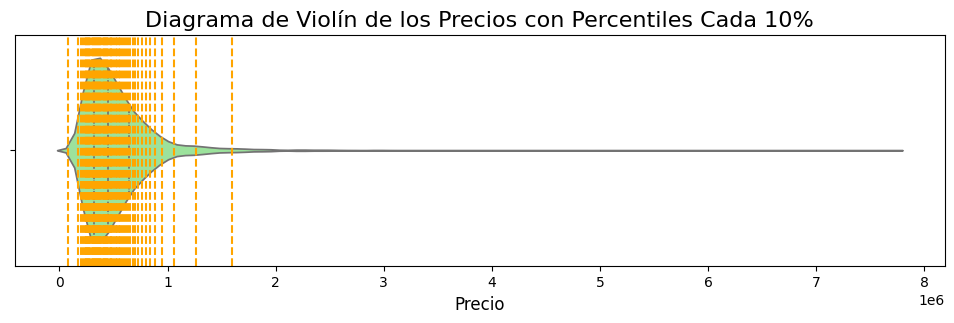

In [59]:
# Calcular los percentiles cada 2%
percentiles = np.percentile(df['price'], np.arange(0, 100, 2))

# Crear el diagrama de violín
plt.figure(figsize=(12, 3))
sns.violinplot(x=df['price'], inner='quartiles', color='lightgreen')

# Añadir las líneas de percentiles cada 2%
for p in percentiles:
    plt.axvline(p, color='orange', linestyle='--', label=f'{int(p)}')

# Títulos y etiquetas
plt.title('Diagrama de Violín de los Precios con Percentiles Cada 10%', fontsize=16)
plt.xlabel('Precio', fontsize=12)

# Mostrar el gráfico
plt.show()

In [60]:
p98 = df['price'].quantile(0.98)

# Usar clip para ajustar los valores mayores a p98
df_filtered = df.copy()  # Hacemos una copia del dataframe para evitar modificar el original
df_filtered['price'] = df_filtered['price'].clip(upper=p98)

In [61]:
mapa2 = crear_mapa(df_filtered, 'price', 'clipped') 

El mapa y los datos ya existen como mapa_coloreado_por_price_de_clipped.html y puntos_coloreados_por_price_de_clipped.json. Abriendo el mapa...


#### Analizamos la posibilidad sustituir el codigo postal con su precio medio de venta correspondiente para intentar mejorar el desempeño de posibles modelos predictivos

In [62]:
X_train_map = X_train_base.copy()
X_test_map = X_test_base.copy()

In [63]:
# Calcular las frecuencias absolutas y normalizadas para verificar que no haya codigos postales con baja frecuencia
frequencies_abs = X_train_map['zipcode'].value_counts()
frequencies_norm = X_train_map['zipcode'].value_counts(normalize=True)

# Crear un DataFrame con ambas columnas
df_counts = pd.DataFrame({
    'Frecuencia Absoluta': frequencies_abs,
    'Frecuencia Normalizada': frequencies_norm
})

df_counts_sorted = df_counts.sort_values(by='Frecuencia Absoluta', ascending = True)
df_counts_sorted.head(7)

,Frecuencia Absoluta,Frecuencia Normalizada
zipcode,,
98039,44,0.002547
98148,49,0.002836
98024,70,0.004052
98102,84,0.004862
98010,84,0.004862
98109,87,0.005036
98070,91,0.005267


Como cada código postal tiene más de 30 observaciones podemos suponer por TCL que la media en el precio de venta de las casas pertenecientes a cada codigo postal tendera a la media poblacional. 

In [64]:
train_map = pd.concat([X_train_map, y_train], axis = 1)
test_map = pd.concat([X_test_map, y_test], axis = 1)

In [65]:
# Calcula el precio medio por zipcode en el conjunto de entrenamiento
mean_price_by_zipcode = train_map.groupby(train_map["zipcode"])["price"].mean()

In [66]:
mean_price_by_zipcode

zipcode
98001    2.850185e+05
98002    2.360403e+05
98003    2.957445e+05
98004    1.311049e+06
98005    8.211968e+05
             ...     
98177    6.673594e+05
98178    3.139207e+05
98188    2.934362e+05
98198    2.974448e+05
98199    7.975363e+05
Name: price, Length: 70, dtype: float64

In [67]:
# Convierte el resultado a un diccionario
mean_price_by_zipcode_dict = mean_price_by_zipcode.to_dict()
mean_price_by_zipcode_dict;

In [68]:
# Agrega la columna 'zipcode_encoded' en train_map y test_map usando el diccionario
train_map["zipcode_encoded"] = train_map["zipcode"].map(mean_price_by_zipcode_dict)
test_map["zipcode_encoded"] = test_map["zipcode"].map(mean_price_by_zipcode_dict)

In [69]:
# Verifica los valores codificados
print(train_map[["zipcode", "zipcode_encoded"]].head())

       zipcode  zipcode_encoded
6243     98144    586352.394052
8986     98045    438483.804233
9419     98074    680862.667630
10155    98034    527501.660088
10436    98103    586504.655242


In [70]:
mean_price_by_zipcode[[98144, 98045, 98074, 98034, 98103]]

zipcode
98144    586352.394052
98045    438483.804233
98074    680862.667630
98034    527501.660088
98103    586504.655242
Name: price, dtype: float64

<Figure size 640x480 with 0 Axes>

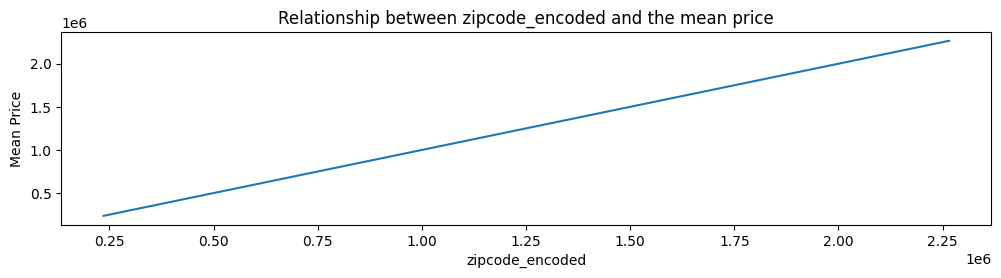

In [71]:
fig = plt.figure()
plt.figure(figsize=(12, 2.5))
fig = y_train.groupby(train_map["zipcode_encoded"])["price"].mean().plot()
fig.set_title("Relationship between {} and the mean price".format("zipcode_encoded"))
fig.set_ylabel("Mean Price")
plt.show();

<Figure size 640x480 with 0 Axes>

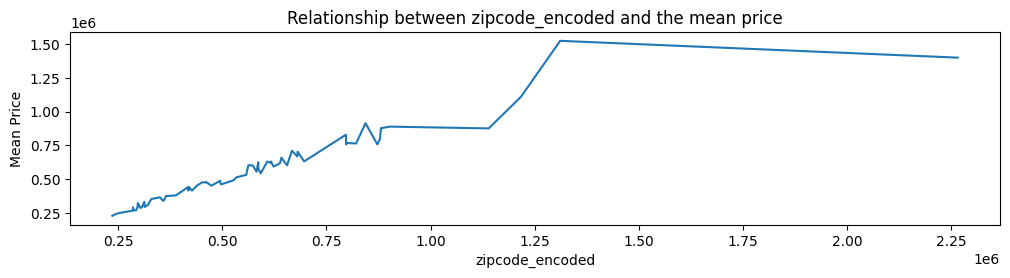

In [72]:
fig = plt.figure()
plt.figure(figsize=(12, 2.5))
fig = y_test.groupby(test_map["zipcode_encoded"])["price"].mean().plot()
fig.set_title("Relationship between {} and the mean price".format("zipcode_encoded"))
fig.set_ylabel("Mean Price")
plt.show();

In [73]:
# La relación monotona de zipcode_encoded con el precio es aceptable

In [74]:
X_train_map["zipcode_encoded"] = X_train_map["zipcode"].map(mean_price_by_zipcode_dict)
X_test_map["zipcode_encoded"] = X_test_map["zipcode"].map(mean_price_by_zipcode_dict)

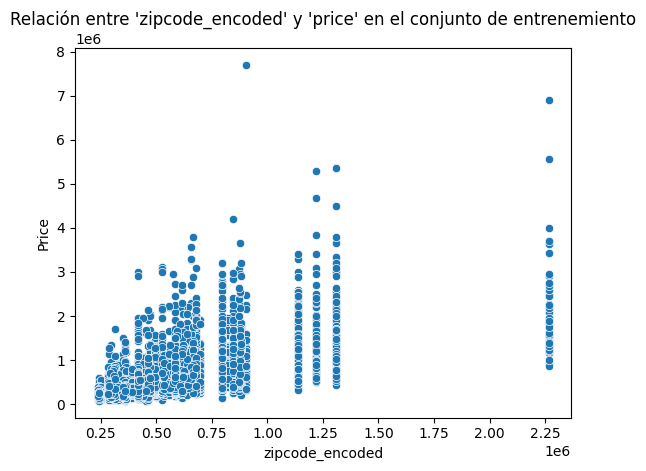

In [75]:
# Crear el scatter plot
sns.scatterplot(x = X_train_map["zipcode_encoded"], y = y_train.values.ravel())

# Personalizar el gráfico (opcional)
plt.title("Relación entre 'zipcode_encoded' y 'price' en el conjunto de entrenemiento")
plt.xlabel("zipcode_encoded")
plt.ylabel("Price")

# Mostrar el gráfico
plt.show()

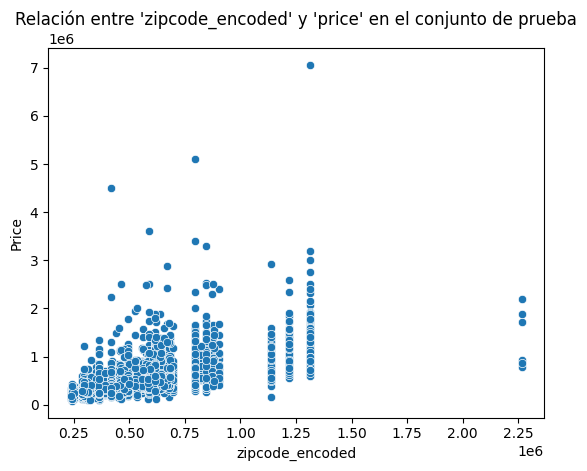

In [76]:
# Crear el scatter plot
sns.scatterplot(x = X_test_map["zipcode_encoded"], y = y_test.values.ravel())

# Personalizar el gráfico (opcional)
plt.title("Relación entre 'zipcode_encoded' y 'price' en el conjunto de prueba")
plt.xlabel("zipcode_encoded")
plt.ylabel("Price")

# Mostrar el gráfico
plt.show()

In [77]:
class MapZipcode(BaseEstimator, TransformerMixin):
    def __init__(self, mapping_dict):
        self.mapping_dict = mapping_dict

    def fit(self, X, y=None):
        # No necesitamos hacer ajuste, solo guardar el diccionario
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Realizamos el mapeo en la columna 'zipcode'
        X_copy['zipcode_encoded'] = X_copy['zipcode'].map(self.mapping_dict)
        return X_copy

In [78]:
# Para el pipeline
zipcode_mapper = MapZipcode(mean_price_by_zipcode_dict)

### Vericar los tipos de datos y eliminar aquellas caracteristicas que no sean necesarias para el modelo

In [79]:
X_train_type = X_train_map.copy()
X_test_type = X_test_map.copy()

In [80]:
X_test_type.dtypes

id                                 int64
date                      datetime64[ns]
bedrooms                           int64
bathrooms                        float64
sqft_living                        int64
sqft_lot                           int64
floors                           float64
waterfront                         int64
view                               int64
condition                          int64
grade                              int64
sqft_above                         int64
sqft_basement                      int64
yr_built                           int64
yr_renovated                       int64
zipcode                            int64
lat                              float64
long                             float64
sqft_living15                      int64
sqft_lot15                         int64
venta_num                          int64
elapsed_years                      int64
no_renovated                       int32
years_since_renovation             int64
no_basement     

#### Las siguientes características mantenerlas como numéricas ya que son ordinales o bicategoricas

**Enteras:**
- **view**: valoración de la vista de la propiedad (0 a 4, siendo 4 la mejor vista)
- **bedrooms**: cantidad de dormitorios
- **condition**: estado de la vivienda (1 a 5, donde 5 es la mejor condición)
- **grade**: calificación general de la casa (de 1 a 13)
- **sqft_above**: área habitable sobre el nivel del suelo
- **sqft_basement**: área de sótano
- **sqft_living**: metros cuadrados del área habitable
- **sqft_lot**: tamaño del lote (en pies cuadrados)
- **sqft_living15**: área de vivienda para las 15 casas más cercanas
- **sqft_lot15**: área de lote para las 15 casas más cercanas
- **elapsed_years**: antigüedad de la casa
- **years_since_renovation**: años desde la renovación
- **waterfront**: indica si la propiedad tiene acceso a la orilla del agua (1 = sí, 0 = no)
- **no_renovated**: indica si la casa no se renovó
- **no_basement**: indica si la casa no tiene sótano

**Continuas:**
- **floors**: cantidad de pisos en la propiedad
- **bathrooms**: cantidad de baños
- **lat**: latitud
- **long**: longitud
- **zipcode_encoded**: código postal codificado

#### Eliminar:
- 'date', 'yr_built', 'yr_renovated': con ellas se crearon elapsed_years, 
renovate e 
years_since_renovati que mantienen la información. 'date' no se mantiene porque solo se cuenta con datos de las ventas de dos años, lo cual es insuficiente para analizar si el año o el mes de la venta influyó o no en el precio. on
- 'zipcode': la reemplaza 'zipcode_encoded'

In [81]:
drop_features_transformer = DropFeatures(features_to_drop=['date', 'yr_built', 'yr_renovated', 'zipcode', 'id'])
X_train_type = drop_features_transformer.fit_transform(X_train_type)
X_test_type = drop_features_transformer.transform(X_test_type)

In [82]:
X_train_type.dtypes

bedrooms                    int64
bathrooms                 float64
sqft_living                 int64
sqft_lot                    int64
floors                    float64
waterfront                  int64
view                        int64
condition                   int64
grade                       int64
sqft_above                  int64
sqft_basement               int64
lat                       float64
long                      float64
sqft_living15               int64
sqft_lot15                  int64
venta_num                   int64
elapsed_years               int64
no_renovated                int32
years_since_renovation      int64
no_basement                 int32
zipcode_encoded           float64
dtype: object

In [83]:
# Para el pipeline
('drop_features', drop_features_transformer)

('drop_features',
 DropFeatures(features_to_drop=['date', 'yr_built', 'yr_renovated', 'zipcode',
                                'id']))

### Analizar outliers

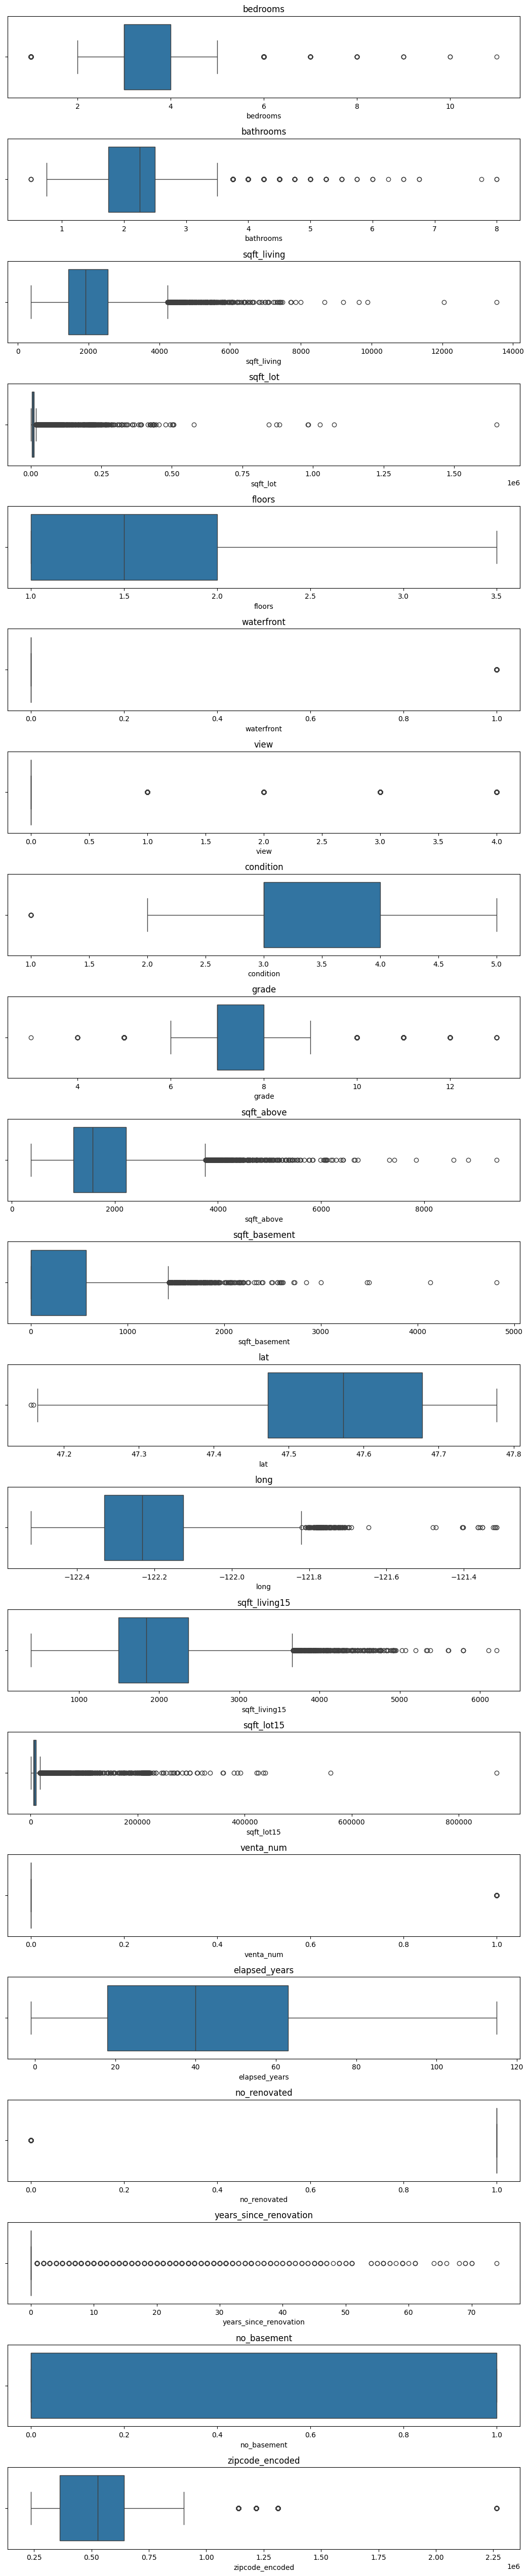

In [84]:
num_vars = len(X_train_type.columns)
num_cols_subplot = 1  # Usar una columna
num_rows_subplot = math.ceil(num_vars / num_cols_subplot)

# Aumentar el tamaño total de la figura
plt.figure(figsize=(15, 5 + (num_rows_subplot - 1) * 3))  # Ajusta el multiplicador según sea necesario

for i, var in enumerate(X_train_type.columns):
    plt.subplot(num_rows_subplot, num_cols_subplot, i + 1)
    sns.boxplot(data=X_train_type, x=var)
    plt.title(var)  # Añadir título a cada subplot

# Ajustar espacio entre filas
plt.subplots_adjust(hspace=0.5, right=0.8)  # Dejar espacio a la derecha para la leyenda

plt.show()

#### Dada la cantidad de outlier no se removeran, en cambio. 
En el siguiente código se filtraban las filas que contenian el 2% de las casas con precio de venta más caras, pero se opto por mantener el total del dataset ya que cuando esten disponibles para vender/comprar nuevas casas no podremos filtrar por los precios ya que no los tendremos

In [85]:
p98 = y_train['price'].quantile(0.98)

y_train_filtered = y_train.copy()
y_test_filtered = y_test.copy()
X_train_filtered = X_train_type.copy()
X_test_filtered = X_test_type.copy()

# y_train_filtered = y_train_filtered[y_train_filtered['price'] <= p98]
# y_test_filtered = y_test_filtered[y_test_filtered['price'] <= p98] 

# X_train_filtered = X_train_filtered.loc[y_train_filtered.index].copy()
# X_test_filtered = X_test_filtered.loc[y_test_filtered.index].copy()

# print(f'Se filtraron {y_train.shape[0] - y_train_filtered.shape[0]} filas del conjunto de entrenamiento')
# print(f'Se filtraron {y_test.shape[0] - y_test_filtered.shape[0]} filas del conjunto de entrenamiento')

In [86]:
# Para el pipeline
# Los pipeline no pueden filtrar la varible dependiente, entonces para este caso, puedo que filtrar antes o después de aplicar el pipeline

### Escalar

In [87]:
X_train_scaled = X_train_filtered.copy()
X_test_scaled = X_test_filtered.copy()

In [88]:
scaler = MinMaxScaler().set_output(transform="pandas")

In [89]:
# Filtrar las columnas cuyo valor máximo sea mayor a 1
columns_to_scale = X_train_scaled.columns[(X_train_scaled.max() > 1) | (X_train_scaled.max() < 0)]
columns_to_scale

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'elapsed_years',
       'years_since_renovation', 'zipcode_encoded'],
      dtype='object')

In [90]:
scaler.fit(X_train_scaled[columns_to_scale])

MinMaxScaler()

In [91]:
X_train_scaled[columns_to_scale] = scaler.transform(X_train_scaled[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

In [92]:
X_train_scaled.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,venta_num,elapsed_years,no_renovated,years_since_renovation,no_basement,zipcode_encoded
count,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,...,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000,17277.000000
mean,0.237489,0.215275,0.130106,0.008765,0.197997,0.007640,0.058184,0.602680,0.465775,0.157117,...,0.650884,0.253641,0.273329,0.013947,0.006135,0.382386,0.958037,0.010307,0.393587,0.150538
std,0.090440,0.102357,0.069670,0.024350,0.216378,0.087076,0.191711,0.162705,0.116882,0.091371,...,0.222772,0.117563,0.117607,0.031046,0.078090,0.253098,0.200511,0.065195,0.488559,0.117057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.166667,0.080486,0.002750,0.000000,0.000000,0.000000,0.500000,0.400000,0.091814,...,0.508123,0.157807,0.187747,0.005111,0.000000,0.163793,1.000000,0.000000,0.000000,0.061825
50%,0.200000,0.233333,0.117692,0.004294,0.200000,0.000000,0.000000,0.500000,0.400000,0.132743,...,0.670742,0.239203,0.247978,0.008005,0.000000,0.353448,1.000000,0.000000,0.000000,0.143631
75%,0.300000,0.266667,0.165528,0.006179,0.400000,0.000000,0.000000,0.750000,0.500000,0.204646,...,0.840277,0.327243,0.337463,0.010841,0.000000,0.551724,1.000000,0.000000,1.000000,0.199991
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [93]:
class CustomScalerWithColumnGroups(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_scale):
        """
        Constructor para la clase de escalado. Recibe las columnas que se deben escalar.
        
        Parameters:
        columns_to_scale (list): Lista de nombres de columnas que serán escaladas.
        """
        self.columns_to_scale = columns_to_scale
        self.scaler = MinMaxScaler()  # Usamos MinMaxScaler por defecto, pero se puede cambiar si es necesario

    def fit(self, X, y=None):
        """
        Ajusta el transformador, escalando solo las columnas seleccionadas.
        
        Parameters:
        X (DataFrame): Conjunto de datos con las columnas a escalar
        """
        # Ajusta el escalador solo a las columnas que se deben escalar
        self.scaler.fit(X[self.columns_to_scale])
        return self  # Devuelve el objeto ajustado

    def transform(self, X):
        """
        Transforma los datos escalando solo las columnas seleccionadas.
        
        Parameters:
        X (DataFrame): Conjunto de datos a transformar
        
        Returns:
        X_final (DataFrame): Los datos transformados con las columnas escaladas y el resto sin cambios
        """
        # Dividir las columnas en dos grupos: las que se van a escalar y las que no
        X_scaled = X[self.columns_to_scale]  # Columnas que serán escaladas
        X_non_scaled = X.drop(columns=self.columns_to_scale)  # Columnas que no serán escaladas
        
        # Escalar solo las columnas seleccionadas
        X_scaled = self.scaler.transform(X_scaled)
        
        # Reconstruir el DataFrame con las columnas no escaladas y las escaladas
        X_scaled_df = pd.DataFrame(X_scaled, columns=self.columns_to_scale, index=X.index)
        X_final = pd.concat([X_non_scaled, X_scaled_df], axis=1)
        
        return X_final  # Devuelve el DataFrame final

In [94]:
# Para el pipeline
# ('custom_scaler', CustomScalerWithColumnGroups(columns_to_scale=columns_to_scale)),

## Busco el mejor modelo 

In [95]:
X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()

In [96]:
y_train = y_train_filtered.copy()
y_test = y_test_filtered.copy()

In [97]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [98]:
X_train.shape, X_test.shape

((17277, 21), (4320, 21))

In [99]:
y_train.shape, y_test.shape

((17277,), (4320,))

### Defino los espacios y forma de determinar los mejores parametros

In [100]:
def objective_linear(trial, X_train, y_train, metric='neg_mean_squared_error'):
    # Definir los parámetros del modelo en un diccionario
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
    param = {
        'alpha': trial.suggest_float('alpha', 1e-5, 1e2, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
    }
    
    # Seleccionar modelo y parámetros según el tipo de penalización
    if penalty == 'l2':
        model = Ridge(**param)
    elif penalty == 'l1':
        model = Lasso(**param)
    elif penalty == 'elasticnet':
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)
        model = ElasticNet(**param)
    
    # Entrenar y evaluar el modelo
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score


def objective_gbm(trial, X_train, y_train, metric='neg_mean_squared_error'):
    param = {
        'n_estimators': trial.suggest_int("gbm_n_estimators", 50, 200),
        'learning_rate': trial.suggest_float("gbm_learning_rate", 0.01, 0.2),
        'max_depth': trial.suggest_int("gbm_max_depth", 1, 25),
        'min_samples_split': trial.suggest_int("gbm_min_samples_split", 2, 100),
        'min_samples_leaf': trial.suggest_int("gbm_min_samples_leaf", 1, 200),
        'max_features': trial.suggest_categorical("gbm_max_features", ['sqrt', 'log2', None]),
        'random_state': 42
    }
    model = GradientBoostingRegressor(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    return score

def objective_knn(trial, X_train, y_train, metric='neg_mean_squared_error'):
    param = {
        'n_neighbors': trial.suggest_int('knn_n_neighbors', 3, 49, step=2),
        'weights': trial.suggest_categorical('knn_weights', ['uniform', 'distance']),
        'p': trial.suggest_int('knn_p', 1, 2),
    }
    model = KNeighborsRegressor(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    return score

def objective_rf(trial, X_train, y_train, metric='neg_mean_squared_error'):
    param = {
        'n_estimators': trial.suggest_int("rf_n_estimators", 50, 300),
        'max_depth': trial.suggest_int("rf_max_depth", 1, 30),
        'min_samples_split': trial.suggest_int("rf_min_samples_split", 2, 400),
        'min_samples_leaf': trial.suggest_int("rf_min_samples_leaf", 1, 400),
        'max_features': trial.suggest_categorical("rf_max_features", [None, 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical("rf_bootstrap", [True, False]),
        'random_state': 42
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    return score

def objective_dt(trial, X_train, y_train, metric='neg_mean_squared_error'):
    param = {
        'max_depth': trial.suggest_int("dt_max_depth", 1, 20),
        'min_samples_split': trial.suggest_int("dt_min_samples_split", 2, 400),
        'min_samples_leaf': trial.suggest_int("dt_min_samples_leaf", 1, 400),
        'criterion': trial.suggest_categorical("dt_criterion", ["squared_error", "friedman_mse"]),
        'random_state': 42
    }
    model = DecisionTreeRegressor(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    return score

def objective_lgbm(trial, X_train, y_train, metric='neg_mean_squared_error'):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-2, log=True), 
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'random_state': 42,
    }
    model = lgb.LGBMRegressor(**param, verbose=0)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    return score


### Determino la metrica a optimizar y busco los mejores parametros para cada modelo

In [101]:
# Interesa optimizar tanto el recall como la presición
chosen_metric = 'r2'

# Diccionario con nombres de métricas y su forma de llamarlas en `scoring`
metricas_regresion = {
    'mean_squared_error': 'neg_mean_squared_error',
    'root_mean_squared_error': 'neg_mean_squared_error',  # Usar con sqrt para obtener RMSE
    'mean_absolute_error': 'neg_mean_absolute_error',
    'median_absolute_error': 'neg_median_absolute_error',
    'r2': 'r2',
    'adjusted_r2': None  # Calculado manualmente (ver explicación abajo)
}


In [102]:
# Diccionario con los modelos y sus funciones objective correspondientes
model_dict = {
    'lgbm': objective_lgbm,
    'knn': objective_knn,
    'dt': objective_dt,
    'linear': objective_linear,
    'rf': objective_rf,
    'gbm': objective_gbm
}

In [103]:
# Intentar leer el archivo CSV, si no existe, ejecutar la optimización
try:
    # Intentar leer el archivo CSV
    trials_df1 = pd.read_csv("../House Prices/parameters_trials.csv")
    print("Archivo leído correctamente.\n")

except FileNotFoundError:
    # Si el archivo no existe, ejecutar la optimización
    print("Archivo no encontrado. Ejecutando optimización...")

    best_params_df = pd.DataFrame(columns=["model", "params", "score"])  # Agregar columna para la métrica

    # Loop sobre los modelos
    for model_name, objective_func in model_dict.items():
        # Crear el estudio para cada modelo
        study = optuna.create_study(direction='maximize', pruner=HyperbandPruner()) #Cuidado cuando el error se quiere minimizar

        # Optimizar el modelo con Optuna utilizando su función objective correspondiente
        study.optimize(lambda trial: objective_func(trial, X_train, y_train, metric = chosen_metric), n_trials = 100)

        # Obtener los mejores parámetros y la mejor puntuación
        best_params = study.best_params
        best_score = study.best_value  # Obtiene la mejor puntuación (por ejemplo, accuracy o roc_auc)

        # Imprimir mensaje indicando que la búsqueda terminó para el modelo actual
        print(f'Búsqueda en {model_name} finalizada')
        
        # Guardar en el DataFrame usando pd.concat()
        best_params_df = pd.concat([best_params_df, pd.DataFrame([{"model": model_name, 
                                                                   "params": best_params, 
                                                                   "score": best_score}])], ignore_index=True)

    # Guardar los resultados en un archivo CSV
    best_params_df.to_csv("../House Prices/parameters_trials.csv", index=False)
    print("Resultados guardados en parameters_trials.csv")

# Leer el archivo CSV después de guardar
trials_df1 = pd.read_csv("../House Prices/parameters_trials.csv")
print("Archivo leído correctamente después de la optimización.\n")

Archivo leído correctamente.

Archivo leído correctamente después de la optimización.



In [104]:
trials_df1

,model,params,score
0,lgbm,"{'num_leaves': 90, 'max_depth': 10, 'learning_...",0.893045
1,knn,"{'knn_n_neighbors': 9, 'knn_weights': 'distanc...",0.836757
2,dt,"{'dt_max_depth': 16, 'dt_min_samples_split': 4...",0.813038
3,linear,"{'penalty': 'l2', 'alpha': 0.4131456579706073,...",0.818837
4,rf,"{'rf_n_estimators': 217, 'rf_max_depth': 24, '...",0.875101
5,gbm,"{'gbm_n_estimators': 190, 'gbm_learning_rate':...",0.890900


#### Corregir los nombres de los parametros

In [105]:
def remove_prefix_and_modify_params(params, model_name, prefix):
    
    # Eliminar el prefijo de los parámetros
    new_params = {}
    for key, value in params.items():

        # Eliminar el prefijo y mantener el valor del parámetro
        if key.startswith(prefix):
            new_key = key[len(prefix):]  # Eliminar el prefijo
        else:
            new_key = key  # Si no tiene prefijo, usamos la clave original

        new_params[new_key] = value
    
    return new_params

# Recorremos cada fila del DataFrame y removemos el prefijo de los parámetros
for index, row in trials_df1.iterrows():
    # Cargar los parámetros de la columna 'params' como diccionario
    params = eval(row['params'])  # Convertir string a diccionario

    # Obtener el nombre del modelo
    model_name = row['model']
    
    # Si el modelo es 'lgbm' o 'linear', no hay prefijo; en otros casos, usamos el nombre del modelo seguido de un guion bajo
    if model_name in ["lgbm", "linear"]:
        prefix = ""
    else:
        prefix = f"{model_name}_"

    # Remover el prefijo y cambiar 'c' a 'C' si es necesario
    new_params = remove_prefix_and_modify_params(params, model_name, prefix)

    # Actualizar la columna 'params' con los nuevos parámetros sin prefijo
    trials_df1.at[index, 'params'] = new_params

# Imprimir el DataFrame actualizado después de la depuración
print("\nDataFrame actualizado:")
print(trials_df1)


DataFrame actualizado:
    model                                             params     score
0    lgbm  {'num_leaves': 90, 'max_depth': 10, 'learning_...  0.893045
1     knn  {'n_neighbors': 9, 'weights': 'distance', 'p': 1}  0.836757
2      dt  {'max_depth': 16, 'min_samples_split': 42, 'mi...  0.813038
3  linear  {'penalty': 'l2', 'alpha': 0.4131456579706073,...  0.818837
4      rf  {'n_estimators': 217, 'max_depth': 24, 'min_sa...  0.875101
5     gbm  {'n_estimators': 190, 'learning_rate': 0.04793...  0.890900


#### Evaluación de los modelos encontrados

In [106]:
def resultados_regresion(y, y_pred, X=None):
    """
    Esta función evalúa el rendimiento de un modelo de regresión utilizando
    el error cuadrático medio (MSE), el error absoluto medio (MAE), el R²,
    el R² ajustado y el RMSE. También incluye visualizaciones de los errores
    y de la predicción vs. valores reales.
    
    Parámetros:
    - y: array-like, valores verdaderos de las etiquetas (valores reales).
    - y_pred: array-like, valores predichos por el modelo (predicciones).
    - X: array-like, características del modelo (opcional, necesario para calcular el R² ajustado).
    """
    # Calcular las métricas de regresión
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)  # Calcular el RMSE
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Si las características X son proporcionadas, calcular el R² ajustado
    if X is not None:
        n = len(y)  # Número de observaciones
        p = X.shape[1]  # Número de características (variables independientes)
        r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        r2_adj = None
    
    # Configuración de la figura
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Dos subfiguras
    
    # Graficar Predicción vs Valores reales
    axes[0].scatter(y, y_pred, alpha=0.6, edgecolors="w", linewidth=0.5)
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Línea de referencia
    axes[0].set_title("Predicción vs Valores Reales")
    axes[0].set_xlabel("Valores Reales")
    axes[0].set_ylabel("Predicciones")
    
    # Graficar los residuos (errores)
    residuals = y - y_pred
    sns.histplot(residuals, kde=True, color='blue', ax=axes[1], bins=30)
    axes[1].set_title("Distribución de Errores (Residuos)")
    axes[1].set_xlabel("Error")
    axes[1].set_ylabel("Frecuencia")
    
    # Ajuste de la visualización
    plt.tight_layout()
    plt.show()

    # Imprimir las métricas
    print(f'Error Cuadrático Medio (MSE): {mse:.3f}')
    print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.3f}')
    print(f'Error Absoluto Medio (MAE): {mae:.3f}')
    print(f'R²: {r2:.3f}')
    if r2_adj is not None:
        print(f'R² Ajustado: {r2_adj:.3f}')

In [107]:
def model_evaluation(model, X_train, y_train, metric='neg_mean_squared_error'):
    """
    Esta función evalúa el rendimiento del modelo utilizando K-Fold Cross-Validation
    y devuelve métricas de rendimiento, así como el riesgo de sobreajuste.

    Parámetros:
    - model: el modelo a evaluar.
    - X_train: conjunto de datos de entrenamiento.
    - y_train: etiquetas del conjunto de entrenamiento.

    Retorna:
    - df: DataFrame con las métricas de rendimiento.
    - overfitting_risk: diccionario con información sobre el riesgo de sobreajuste.
    """
    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    try:
        # Estimación del error de generalización
        clf = cross_validate(
            model,
            X_train,
            y_train,
            scoring= metric,
            return_train_score=True,
            cv=kf
        )

        # Calcular valores para el conjunto de entrenamiento
        mean_train_score = np.mean(clf['train_score'])
        std_train_score = np.std(clf['train_score'])

        # Calcular el intervalo para el conjunto de entrenamiento
        interval_lower_train = mean_train_score - 3 * std_train_score
        interval_upper_train = mean_train_score + 3 * std_train_score

        # Calcular el puntaje medio y el intervalo para el conjunto de prueba
        mean_test_score = np.mean(clf['test_score']) if 'test_score' in clf else np.nan
        std_test_score = np.std(clf['test_score']) if 'test_score' in clf else np.nan

        # Calcular el intervalo para el conjunto de prueba
        interval_lower_test = mean_test_score - 3 * std_test_score if not np.isnan(mean_test_score) else np.nan
        interval_upper_test = mean_test_score + 3 * std_test_score if not np.isnan(mean_test_score) else np.nan

        # Crear el DataFrame con las métricas
        df = pd.DataFrame({
            'mean': [mean_train_score, mean_test_score],
            'std': [std_train_score, std_test_score],
            'interval_lower': [interval_lower_train, interval_lower_test],
            'interval_upper': [interval_upper_train, interval_upper_test]
        }, index=['train_set', 'test_set'])

        # Prueba t para comparar las puntuaciones de entrenamiento y prueba
        t_stat, p_value = stats.ttest_ind(clf['train_score'], clf['test_score'], equal_var=False)

        # Diccionario con la probabilidad de sobreajuste
        overfitting_risk = {
            't_statistic': t_stat,
            'p_value': p_value,
            'overfitting_likelihood': 'High' if p_value < 0.10 else 'Low'
        }

        return df, overfitting_risk

    except Exception as e:
        print(f"Error al evaluar el modelo: {e}")
        return None, None

#### Dado que linear puede toma uno de tres modelos (Ridge, Lasso, ElasticNet) necesito saber cual es el modelo que mejor resultados dió

In [108]:
# Función para determinar el modelo adecuado según el 'penalty'
def get_linear_model(params):
    penalty = params.get('penalty', None)
    if penalty == 'l2':
        return Ridge
    elif penalty == 'l1':
        return Lasso
    elif penalty == 'elasticnet':
        return ElasticNet
    else:
        raise ValueError(f"Penalización '{penalty}' no reconocida")

# Obtener los parámetros del modelo 'linear'
linear_params = trials_df1[trials_df1['model'] == 'linear']['params'].iloc[0]

# Asignar el modelo correcto a 'linear' en el diccionario
linear_model = get_linear_model(linear_params)
linear_model

sklearn.linear_model._ridge.Ridge

In [109]:
# Diccionario con los modelos y sus funciones objective correspondientes
model_dict = {
    'lgbm': lgb.LGBMRegressor,
    'knn': KNeighborsRegressor,
    'dt': DecisionTreeRegressor,
    'linear': linear_model,
    'rf': RandomForestRegressor,
    'gbm': GradientBoostingRegressor
}

#### Una vez que pudimos obtener cual es el modelo linear_model devemos eliminar el parametro penalty del modelo

In [110]:
# Eliminar el parámetro 'penalty' de los modelos 'linear'
trials_df1.loc[trials_df1['model'] == 'linear', 'params'] = trials_df1.loc[trials_df1['model'] == 'linear', 'params'].apply(lambda x: {k: v for k, v in x.items() if k != 'penalty'})

In [111]:
trials_df1

,model,params,score
0,lgbm,"{'num_leaves': 90, 'max_depth': 10, 'learning_...",0.893045
1,knn,"{'n_neighbors': 9, 'weights': 'distance', 'p': 1}",0.836757
2,dt,"{'max_depth': 16, 'min_samples_split': 42, 'mi...",0.813038
3,linear,"{'alpha': 0.4131456579706073, 'max_iter': 892}",0.818837
4,rf,"{'n_estimators': 217, 'max_depth': 24, 'min_sa...",0.875101
5,gbm,"{'n_estimators': 190, 'learning_rate': 0.04793...",0.890900


In [112]:
# Nombre del archivo CSV relacionado con "comportamiento_mejores_parametros"
csv_filename = "best_params_results.csv"

# Verifica si el archivo ya existe
if os.path.exists(csv_filename):
    # Si el archivo existe, solo se lee y se omite el proceso de evaluación y guardado
    results_df = pd.read_csv(csv_filename)
    print("El archivo ya existe. Se han cargado los resultados desde el archivo.")
else:
    # Si el archivo no existe, se realiza el cálculo y se guarda el archivo
    results_df = pd.DataFrame(columns=["model", "mean_train_score", "std_train_score", "interval_lower_train", 
                                       "interval_upper_train", "mean_test_score", "std_test_score", 
                                       "interval_lower_test", "interval_upper_test", "overfitting_risk", "p_value"])

    # Para cada modelo en trials_df1, crea y entrena el modelo utilizando los parámetros
    for index, row in trials_df1.iterrows():
        model_name = row['model']
        params = row['params']

        # # Si el modelo es 'lgbm', no necesita prefijo como los otros modelos
        # if model_name != 'lgbm':
        #     # Remover el prefijo (modelo_name + "_") de los parámetros
        #     params = {k.replace(f'{model_name}_', ''): v for k, v in params.items()}

        # Crear el modelo usando los parámetros
        model_class = model_dict[model_name]
        model = model_class(**params)

        # Evaluar el modelo usando la función 'model_evaluation'
        df, overfitting_risk = model_evaluation(model, X_train, y_train, metric = chosen_metric)

        # Extraer los resultados de la evaluación
        mean_train_score = df.loc['train_set', 'mean']
        std_train_score = df.loc['train_set', 'std']
        interval_lower_train = df.loc['train_set', 'interval_lower']
        interval_upper_train = df.loc['train_set', 'interval_upper']
        
        mean_test_score = df.loc['test_set', 'mean']
        std_test_score = df.loc['test_set', 'std']
        interval_lower_test = df.loc['test_set', 'interval_lower']
        interval_upper_test = df.loc['test_set', 'interval_upper']

        # Extraer el valor p
        p_value = overfitting_risk.get('p_value', 1.0)

        # Crear un diccionario con los resultados para agregar al DataFrame
        results = {
            "model": model_name,
            "mean_train_score": mean_train_score,
            "std_train_score": std_train_score,
            "interval_lower_train": interval_lower_train,
            "interval_upper_train": interval_upper_train,
            "mean_test_score": mean_test_score,
            "std_test_score": std_test_score,
            "interval_lower_test": interval_lower_test,
            "interval_upper_test": interval_upper_test,
            "overfitting_risk": overfitting_risk['overfitting_likelihood'],
            "p_value": p_value
        }

        # Agregar los resultados al DataFrame de resultados
        results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
    
    # Guardar los resultados en el archivo CSV
    results_df.to_csv(csv_filename, index=False)
    print("El archivo ha sido creado y los resultados han sido guardados.")

El archivo ya existe. Se han cargado los resultados desde el archivo.


In [113]:
results_df

,model,mean_train_score,std_train_score,interval_lower_train,interval_upper_train,mean_test_score,std_test_score,interval_lower_test,interval_upper_test,overfitting_risk,p_value
0,lgbm,0.957380,1.411405e-03,0.953146,0.961615,0.893053,0.005006,0.878035,0.908070,High,0.000004
1,knn,1.000000,6.205218e-08,1.000000,1.000000,0.835234,0.009019,0.808176,0.862291,High,0.000003
2,dt,0.875430,1.783258e-03,0.870081,0.880780,0.815295,0.008238,0.790581,0.840008,High,0.000078
3,linear,0.819935,1.719184e-03,0.814778,0.825093,0.818598,0.006721,0.798434,0.838762,Low,0.717318
4,rf,0.997581,3.211015e-05,0.997485,0.997677,0.874535,0.005929,0.856748,0.892322,High,0.000002
5,gbm,0.953244,1.023601e-03,0.950173,0.956315,0.889674,0.004375,0.876549,0.902798,High,0.000004


#### Grafico los resultados para poder compararlos

In [114]:
from matplotlib.colors import Normalize, LinearSegmentedColormap

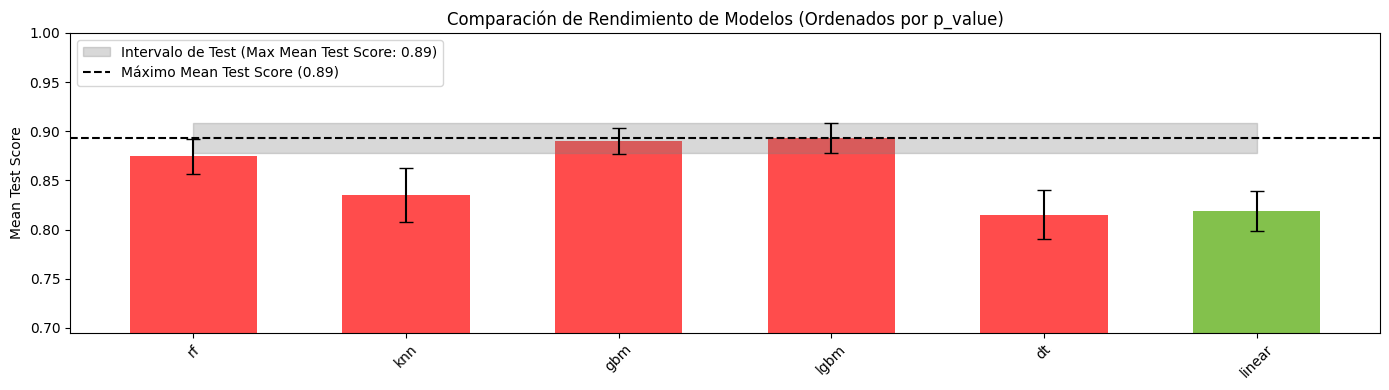

In [115]:
# Ordenar el DataFrame por el valor p creciente
results_df_sorted = results_df.sort_values(by='p_value')

# Crear el gráfico de barras
plt.figure(figsize=(14, 4))  # Ajustar el tamaño de la figura
bar_width = 0.6  # Hacer las barras el doble de anchas

# Obtener todos los modelos únicos después de ordenar
all_models = results_df_sorted['model'].unique()  # Obtener los modelos únicos

# Inicializar posición base
x_pos = np.arange(len(all_models))

# Crear un colormap personalizado para los valores p (ajustado a tus indicaciones)
colors = LinearSegmentedColormap.from_list(
    "p_value_gradient", [(0, 'red'), (0.075, 'yellow'), (1, 'green')])

# Normalizar los valores p de acuerdo con el rango entre 0 y 1
norm = Normalize(vmin=0, vmax=1)

# Graficar las métricas de test (mean_test_score y std_test_score)
max_mean_test_score = -np.inf  # Para encontrar el mayor mean_test_score
interval_lower_test_max = None  # Para almacenar el valor del intervalo inferior
interval_upper_test_max = None  # Para almacenar el valor del intervalo superior
min_mean_test_score = np.inf  # Para encontrar el menor mean_test_score

for i, model in enumerate(all_models):
    # Filtrar los datos para cada modelo
    filtered_df = results_df_sorted[results_df_sorted['model'] == model]
    
    # Obtener las métricas del modelo
    mean_test_score = filtered_df['mean_test_score'].values[0]
    test_std = filtered_df['std_test_score'].values[0] * 3  # Multiplicar la desviación estándar por 3
    p_value = filtered_df['p_value'].values[0]
    
    # Obtener los límites del intervalo de test
    interval_lower_test = filtered_df['interval_lower_test'].values[0]
    interval_upper_test = filtered_df['interval_upper_test'].values[0]
    
    # Actualizar el máximo y el mínimo mean_test_score, así como los límites del intervalo
    if mean_test_score > max_mean_test_score:
        max_mean_test_score = mean_test_score
        interval_lower_test_max = interval_lower_test
        interval_upper_test_max = interval_upper_test
    if mean_test_score < min_mean_test_score:
        min_mean_test_score = mean_test_score

    # Asignar el color basado en el valor p usando el colormap
    color = colors(norm(p_value))  # Aplicar normalización y obtener el color

    # Posicionar las barras
    plt.bar(x_pos[i], mean_test_score, yerr=test_std, capsize=5, 
            color=color, width=bar_width, alpha=0.7)

# Añadir una banda translucida entre interval_lower_test_max y interval_upper_test_max
plt.fill_between(
    [0, len(all_models) - 1],  # Todo el ancho del gráfico
    interval_lower_test_max, interval_upper_test_max,
    color='gray', alpha=0.3, label=f'Intervalo de Test (Max Mean Test Score: {max_mean_test_score:.2f})'
)

# Añadir línea horizontal en el valor máximo de mean_test_score
plt.axhline(y=max_mean_test_score, color='black', linestyle='--', label=f'Máximo Mean Test Score ({max_mean_test_score:.2f})')

# Añadir etiquetas y título
plt.title('Comparación de Rendimiento de Modelos (Ordenados por p_value)')
plt.xticks(x_pos, all_models, rotation=45)
plt.ylabel('Mean Test Score')

# Ajustar el límite del eje y
plt.ylim(min_mean_test_score - 0.12, 1.0)  # Se ajusta el límite inferior para incluir el valor mínimo

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Evaluo el desempeño de los modelos más prometedores

In [116]:
lgbm_best_params = trials_df1[trials_df1['model'] == 'lgbm']['params'].iloc[0]
print(lgbm_best_params)

{'num_leaves': 90, 'max_depth': 10, 'learning_rate': 0.03696238742158522, 'n_estimators': 615, 'min_child_samples': 43, 'min_child_weight': 0.000957613588615844, 'subsample': 0.7891205647616174, 'colsample_bytree': 0.5767378933010041, 'reg_alpha': 0.6890131590749506, 'reg_lambda': 0.40278083720796354}


In [117]:
lgbm_best_params['verbosity'] = -1
lgbm_best_params['random_state'] = 42

In [118]:
lgbm_regressor = lgb.LGBMRegressor(**lgbm_best_params)
lgbm_regressor.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.5767378933010041,
              learning_rate=0.03696238742158522, max_depth=10,
              min_child_samples=43, min_child_weight=0.000957613588615844,
              n_estimators=615, num_leaves=90, random_state=42,
              reg_alpha=0.6890131590749506, reg_lambda=0.40278083720796354,
              subsample=0.7891205647616174, verbosity=-1)

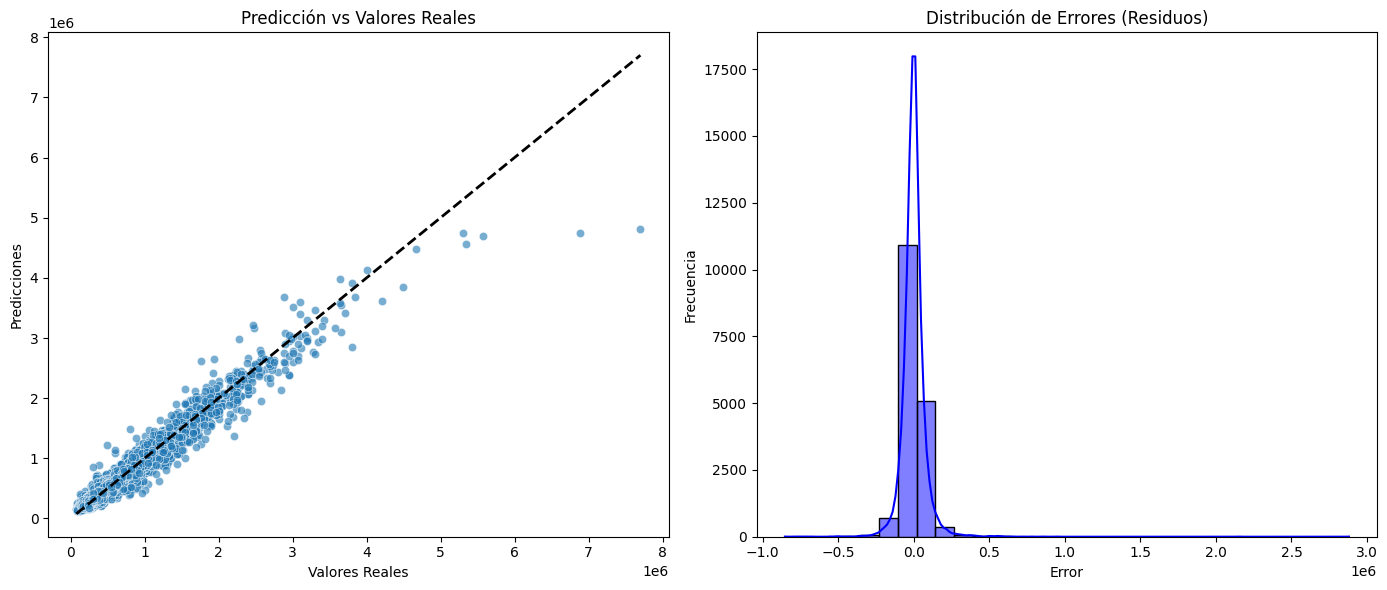

Error Cuadrático Medio (MSE): 6381178974.901
Raíz del Error Cuadrático Medio (RMSE): 79882.282
Error Absoluto Medio (MAE): 48129.933
R²: 0.953
R² Ajustado: 0.953


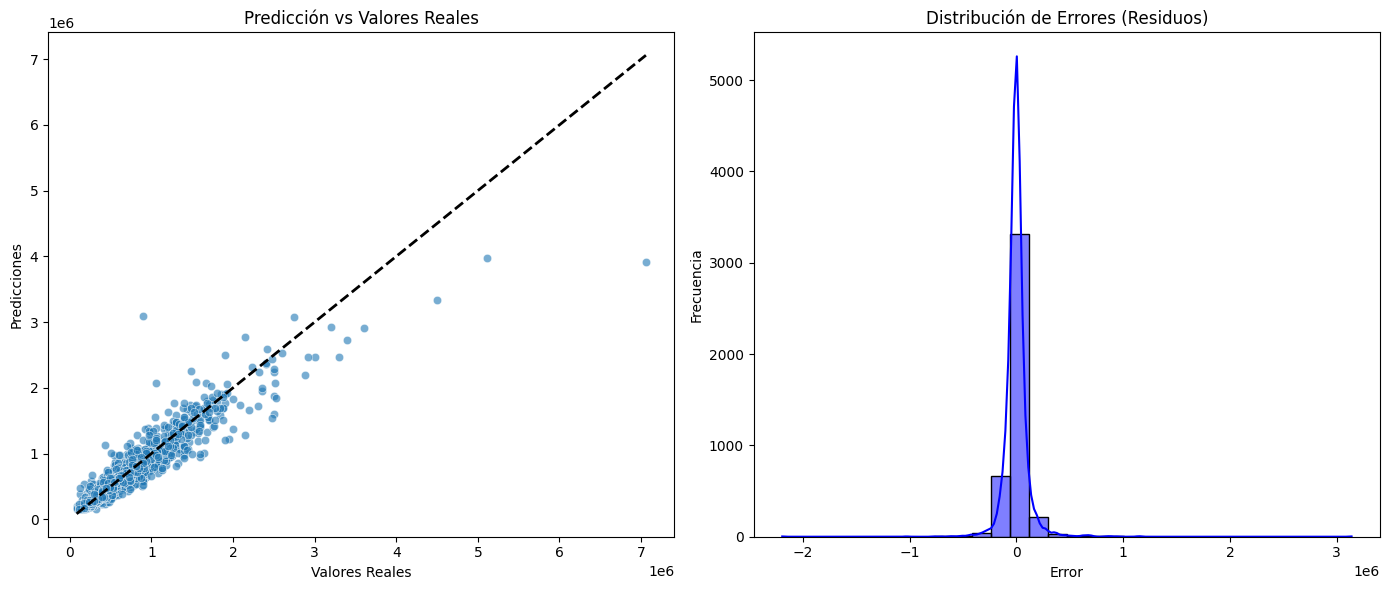

Error Cuadrático Medio (MSE): 14338213752.824
Raíz del Error Cuadrático Medio (RMSE): 119742.281
Error Absoluto Medio (MAE): 62388.319
R²: 0.890
R² Ajustado: 0.889


In [119]:
y_train_pred = lgbm_regressor.predict(X = X_train)
y_test_pred = lgbm_regressor.predict(X = X_test)

resultados_regresion(y_train, y_train_pred, X = X_train)
resultados_regresion(y_test, y_test_pred, X = X_test)

#### Como el valor medio de r2 en la validación cruzada (0.89) es muy similar al r2  obtenido en el conjunto de prueba (0.90), eso indica que el modelo generaliza correctamente.

In [120]:
results_df[results_df['model'] == 'lgbm']

,model,mean_train_score,std_train_score,interval_lower_train,interval_upper_train,mean_test_score,std_test_score,interval_lower_test,interval_upper_test,overfitting_risk,p_value
0,lgbm,0.95738,0.001411,0.953146,0.961615,0.893053,0.005006,0.878035,0.90807,High,0.000004


{'n_estimators': 190, 'learning_rate': 0.04793238585747685, 'max_depth': 23, 'min_samples_split': 28, 'min_samples_leaf': 40, 'max_features': 'log2'}


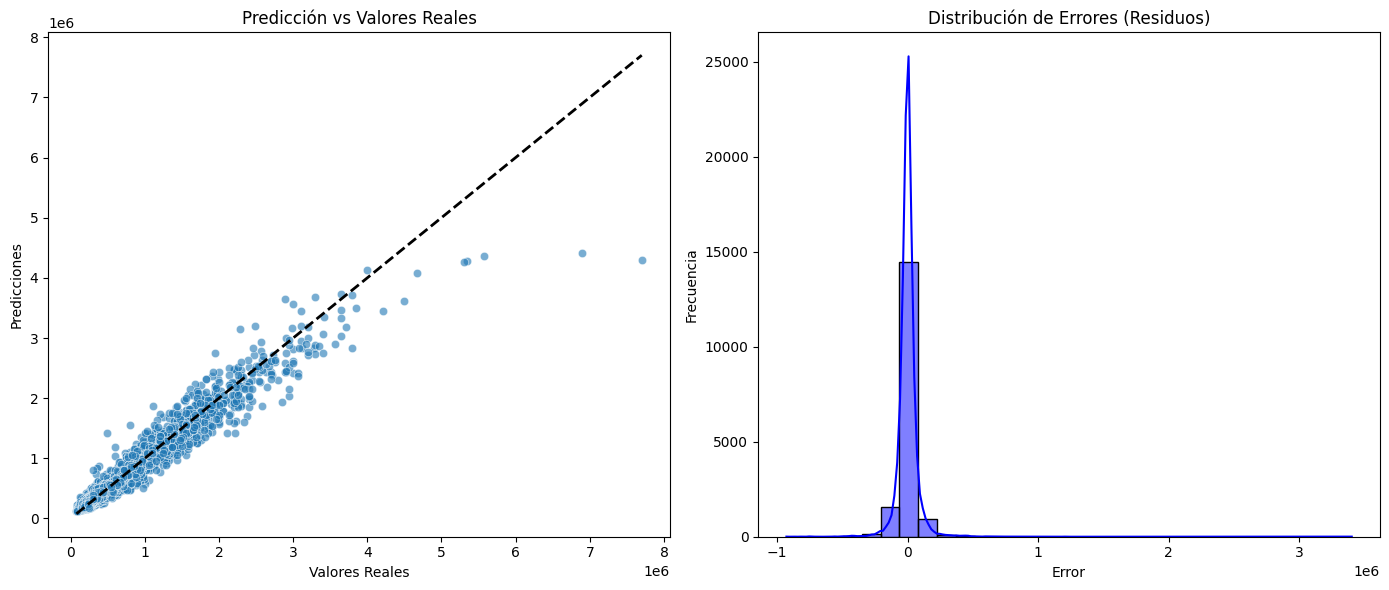

Error Cuadrático Medio (MSE): 6758046697.185
Raíz del Error Cuadrático Medio (RMSE): 82207.340
Error Absoluto Medio (MAE): 43584.441
R²: 0.950
R² Ajustado: 0.950


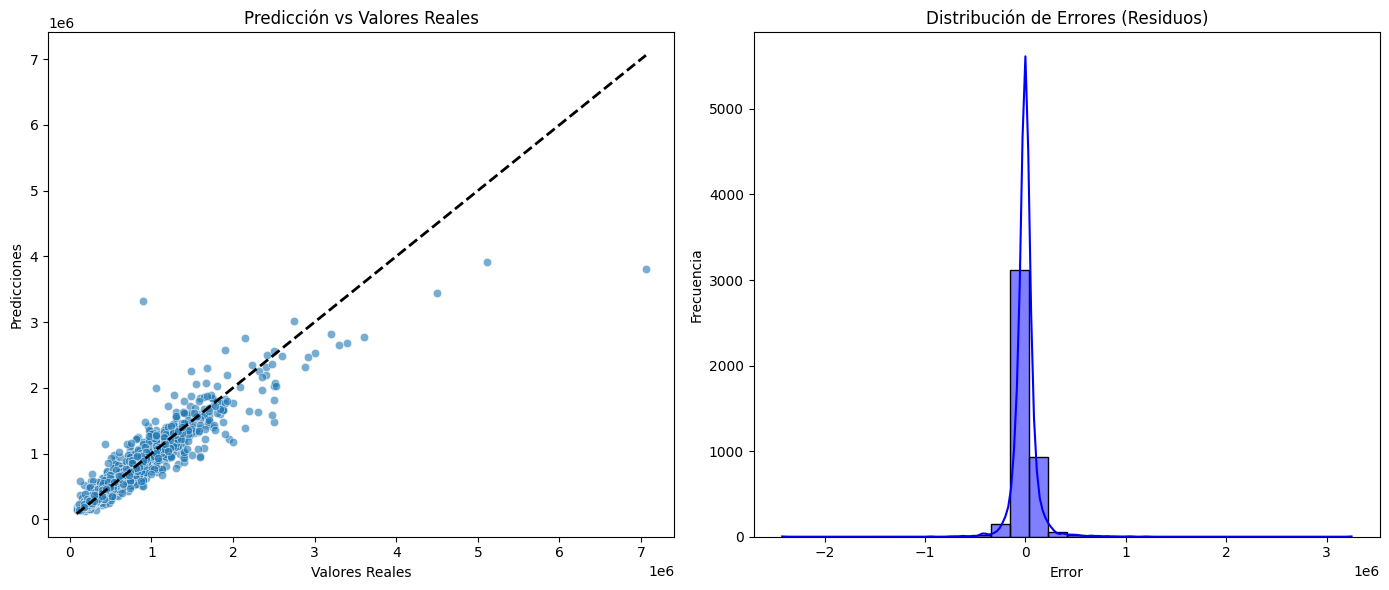

Error Cuadrático Medio (MSE): 15270576034.025
Raíz del Error Cuadrático Medio (RMSE): 123574.172
Error Absoluto Medio (MAE): 63510.173
R²: 0.883
R² Ajustado: 0.882


In [121]:
gbm_best_params = trials_df1[trials_df1['model'] == 'gbm']['params'].iloc[0]
print(gbm_best_params)

gbm_regressor = GradientBoostingRegressor(**gbm_best_params)
gbm_regressor.fit(X_train, y_train)

y_train_pred = gbm_regressor.predict(X = X_train)
y_test_pred = gbm_regressor.predict(X = X_test)

resultados_regresion(y_train, y_train_pred, X = X_train)
resultados_regresion(y_test, y_test_pred, X = X_test)

In [122]:
results_df[results_df['model'] == 'gbm']

,model,mean_train_score,std_train_score,interval_lower_train,interval_upper_train,mean_test_score,std_test_score,interval_lower_test,interval_upper_test,overfitting_risk,p_value
5,gbm,0.953244,0.001024,0.950173,0.956315,0.889674,0.004375,0.876549,0.902798,High,0.000004


{'alpha': 0.4131456579706073, 'max_iter': 892}


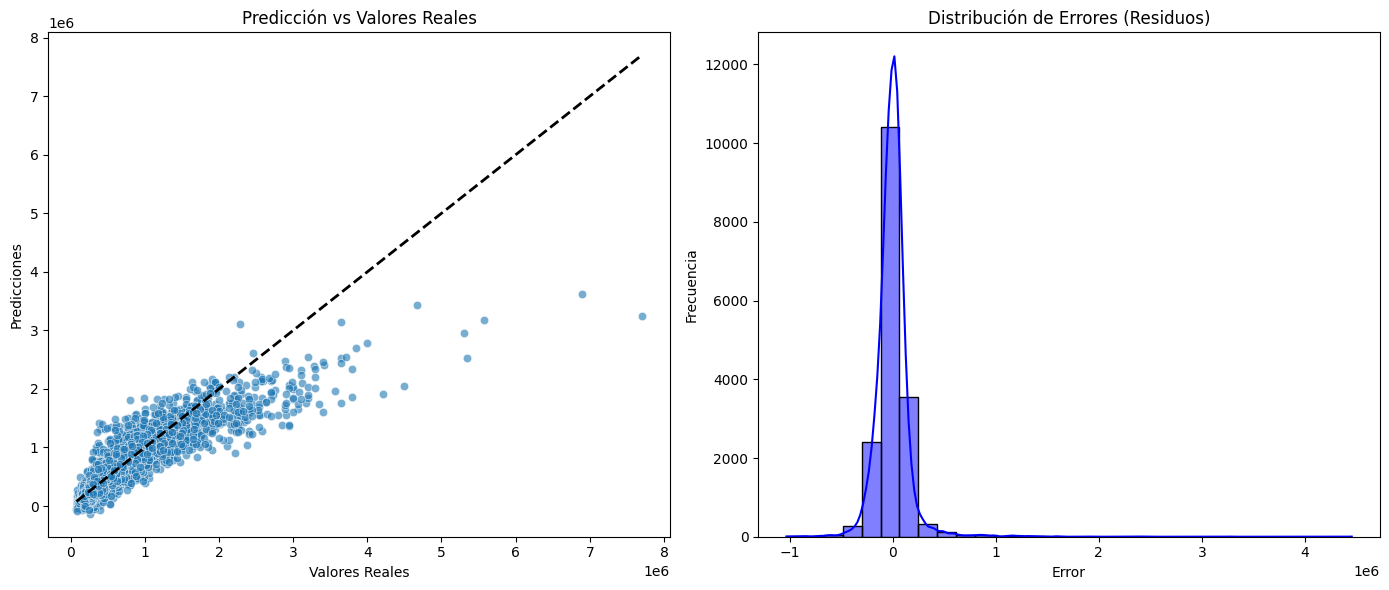

Error Cuadrático Medio (MSE): 27989683552.718
Raíz del Error Cuadrático Medio (RMSE): 167301.176
Error Absoluto Medio (MAE): 100648.152
R²: 0.794
R² Ajustado: 0.794


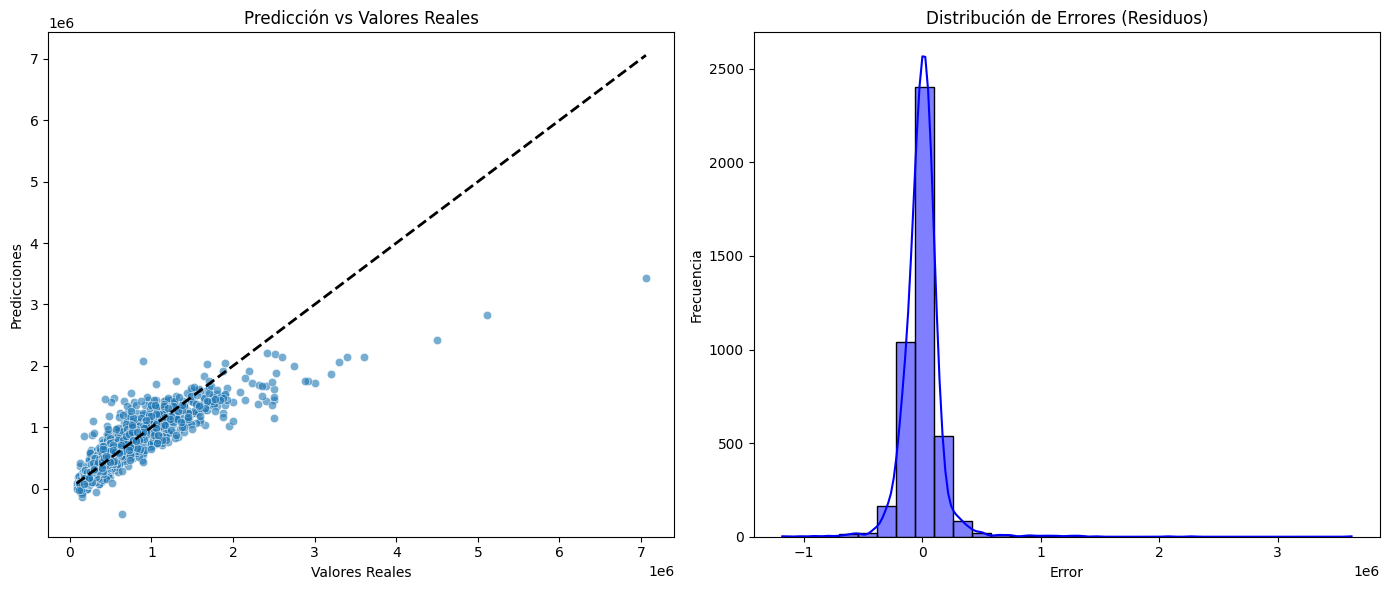

Error Cuadrático Medio (MSE): 29336807873.284
Raíz del Error Cuadrático Medio (RMSE): 171279.911
Error Absoluto Medio (MAE): 101897.747
R²: 0.775
R² Ajustado: 0.774


In [123]:
linear_best_params = trials_df1[trials_df1['model'] == 'linear']['params'].iloc[0]
print(linear_best_params)

linear_regressor = Ridge(**linear_best_params)
linear_regressor.fit(X_train, y_train)

y_train_pred = linear_regressor.predict(X = X_train)
y_test_pred = linear_regressor.predict(X = X_test)

resultados_regresion(y_train, y_train_pred, X = X_train)
resultados_regresion(y_test, y_test_pred, X = X_test)

### Feature selection
Buscamos eliminar la mayor cantidad posible de caracteristicas sin que disminuir el poder predictivo del modelo o incluso mejorarlo. Para ello compararemos los resultados de RFE en GradientBoostingRegressor o LGBMRegressor.

In [124]:
from feature_engine.selection import RecursiveFeatureElimination

In [125]:
# Setup the RFE selector
sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = gbm_regressor, # the ML model
    scoring = 'r2', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=3, # cross-validation
)

In [126]:
# sel.fit(X_train, y_train)

# print(sel.initial_model_performance_)
# 0.888817026942602

# print(sel.performance_drifts_)
# print(sel.features_to_drop_)

# X_train_filtered = sel.transform(X_train)
# X_test_filtered = sel.transform(X_test)

In [127]:
gbm_features_to_drop = ['bedrooms',
                         'bathrooms',       
                         'floors',
                         'sqft_basement',   
                         'sqft_lot15',      
                         'no_basement']

In [128]:
X_train_gbm_filtered = X_train.drop(columns=gbm_features_to_drop).copy()
X_test_gbm_filtered = X_test.drop(columns=gbm_features_to_drop).copy()

In [129]:
X_train_gbm_filtered.shape, X_test_gbm_filtered.shape

((17277, 15), (4320, 15))

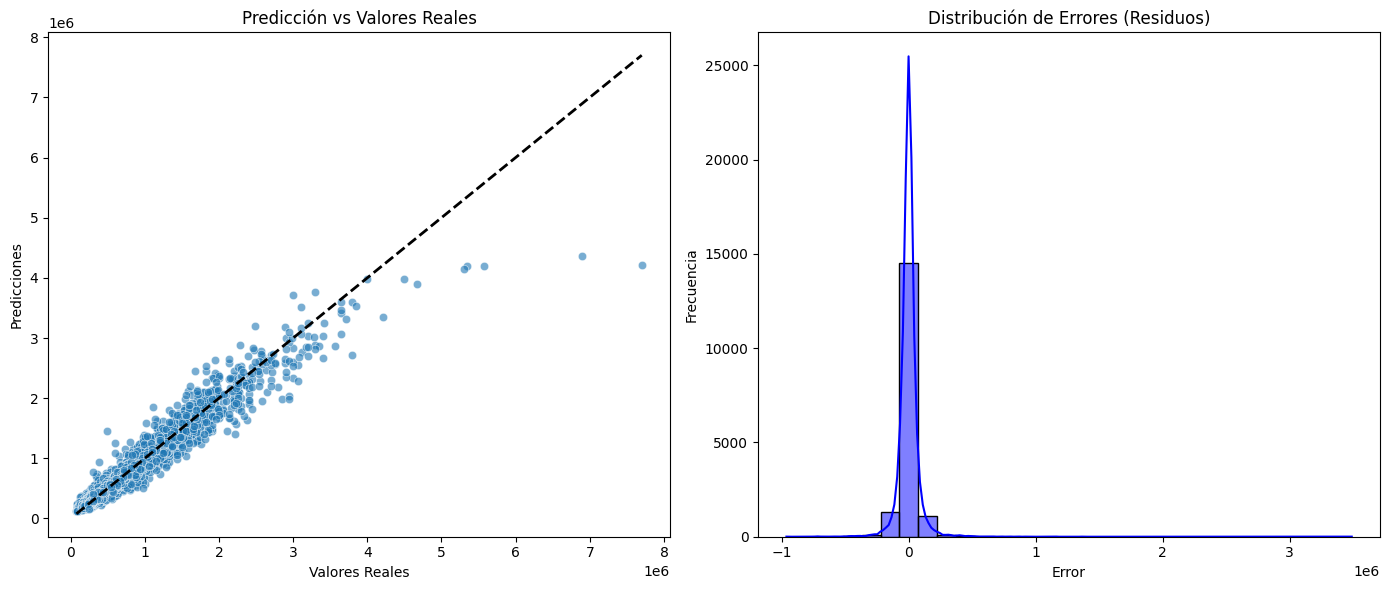

Error Cuadrático Medio (MSE): 7180613762.038
Raíz del Error Cuadrático Medio (RMSE): 84738.502
Error Absoluto Medio (MAE): 45206.320
R²: 0.947
R² Ajustado: 0.947


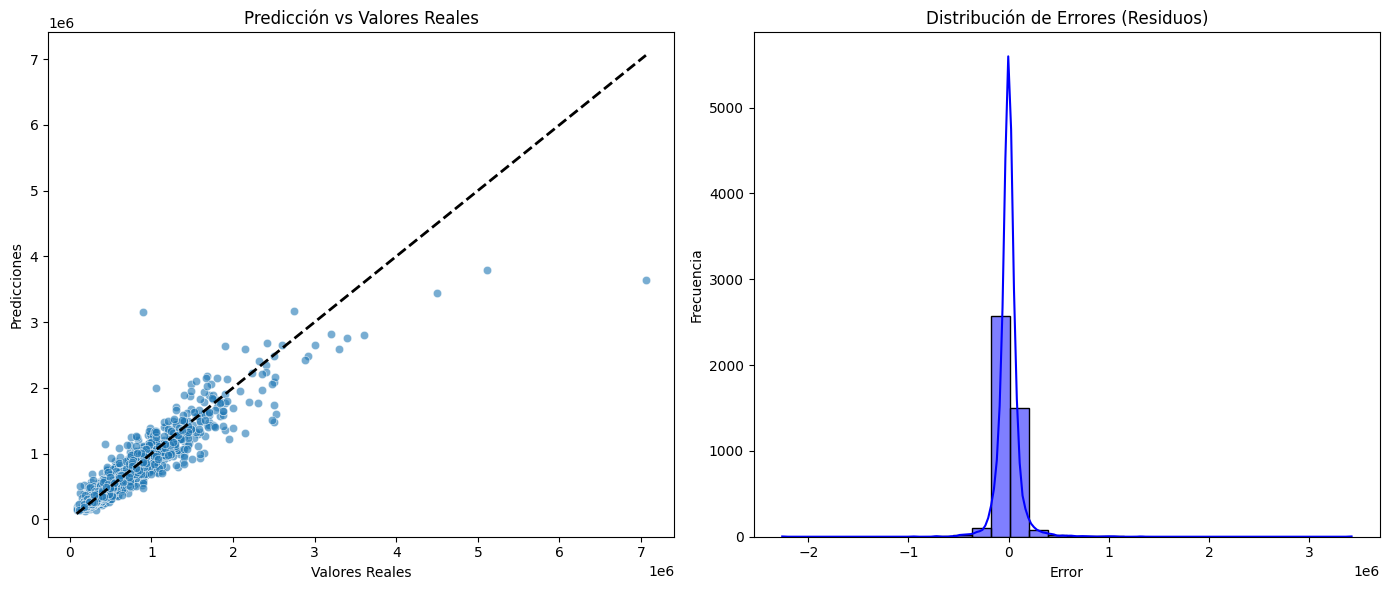

Error Cuadrático Medio (MSE): 15382761214.065
Raíz del Error Cuadrático Medio (RMSE): 124027.260
Error Absoluto Medio (MAE): 63648.207
R²: 0.882
R² Ajustado: 0.881


In [130]:
gbm_regressor.fit(X_train_gbm_filtered, y_train)
y_train_pred = gbm_regressor.predict(X = X_train_gbm_filtered)
y_test_pred = gbm_regressor.predict(X = X_test_gbm_filtered)

resultados_regresion(y_train, y_train_pred, X = X_train_gbm_filtered)
resultados_regresion(y_test, y_test_pred, X = X_test_gbm_filtered)

In [131]:
# Setup the RFE selector
sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = lgbm_regressor, # the ML model
    scoring = 'r2', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=3, # cross-validation
)

In [132]:
# sel.fit(X_train, y_train)
# print(sel.features_to_drop_)
# print(sel.performance_drifts_)
# X_train_filtered = sel.transform(X_train)
# X_test_filtered = sel.transform(X_test)

In [133]:
lgbm_features_to_drop = ['bedrooms',
                         'floors',
                         'sqft_above',
                         'sqft_basement',
                         'sqft_lot15',
                         'no_renovated',
                         'no_basement']

In [134]:
X_train_lgbm_filtered = X_train.drop(columns=lgbm_features_to_drop).copy()
X_test_lgbm_filtered = X_test.drop(columns=lgbm_features_to_drop).copy()

In [135]:
X_train_lgbm_filtered.shape, X_test_lgbm_filtered.shape

((17277, 14), (4320, 14))

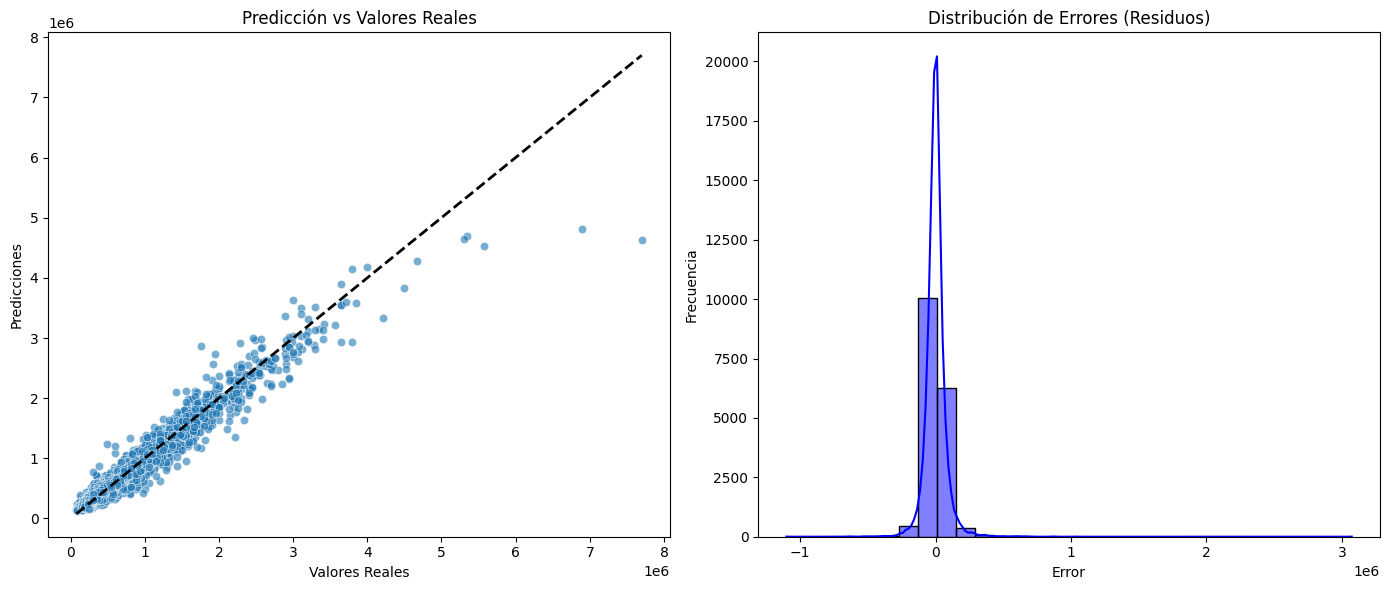

Error Cuadrático Medio (MSE): 6558750685.687
Raíz del Error Cuadrático Medio (RMSE): 80986.114
Error Absoluto Medio (MAE): 48415.283
R²: 0.952
R² Ajustado: 0.952


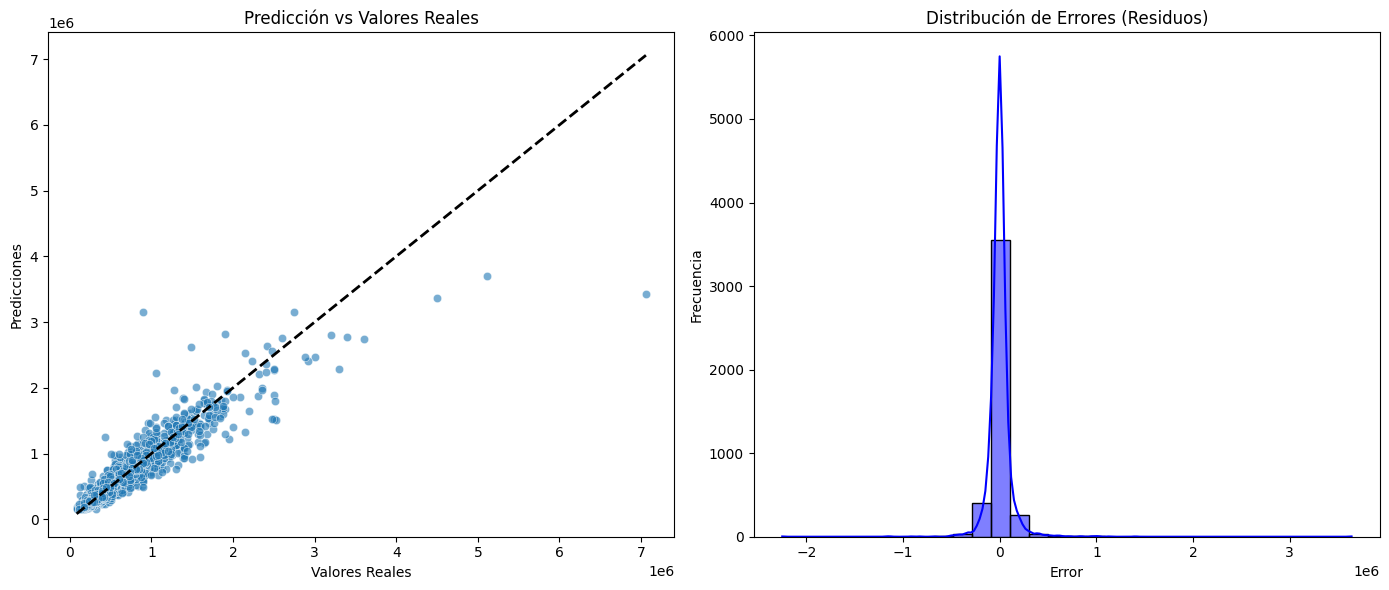

Error Cuadrático Medio (MSE): 16226037991.140
Raíz del Error Cuadrático Medio (RMSE): 127381.466
Error Absoluto Medio (MAE): 63662.692
R²: 0.875
R² Ajustado: 0.875


In [136]:
lgbm_regressor.fit(X_train_lgbm_filtered, y_train)
y_train_pred = lgbm_regressor.predict(X = X_train_lgbm_filtered)
y_test_pred = lgbm_regressor.predict(X = X_test_lgbm_filtered)

resultados_regresion(y_train, y_train_pred, X = X_train_lgbm_filtered)
resultados_regresion(y_test, y_test_pred, X = X_test_lgbm_filtered)

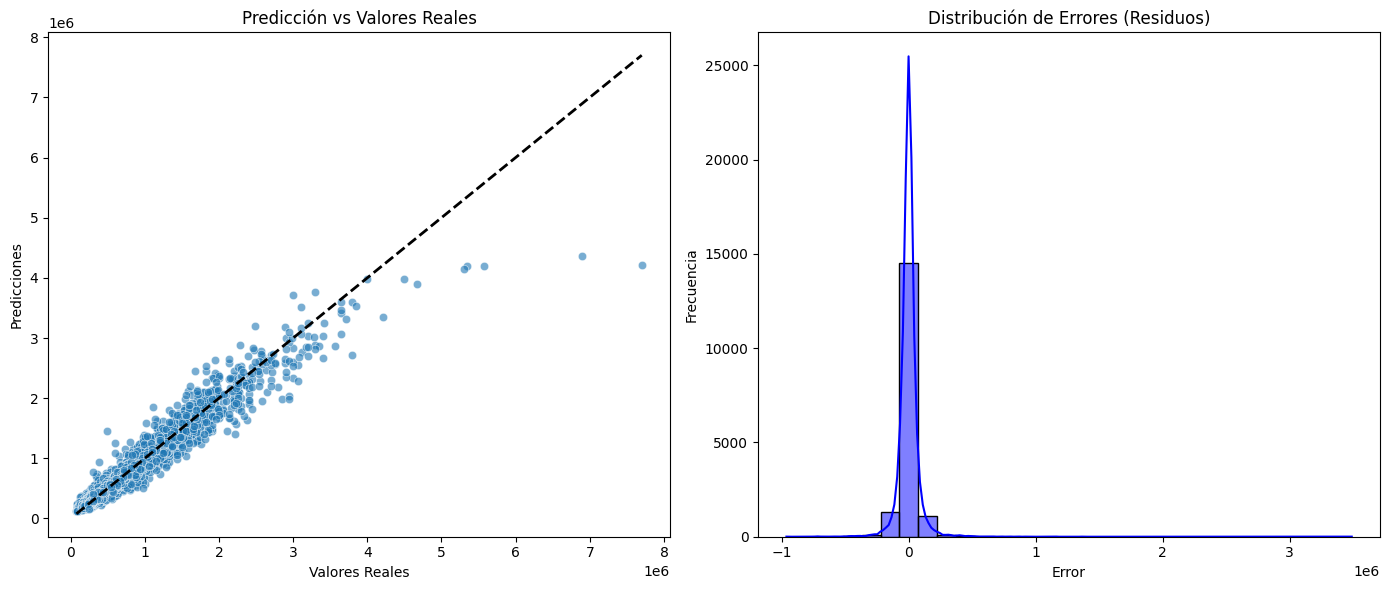

Error Cuadrático Medio (MSE): 7180613762.038
Raíz del Error Cuadrático Medio (RMSE): 84738.502
Error Absoluto Medio (MAE): 45206.320
R²: 0.947
R² Ajustado: 0.947


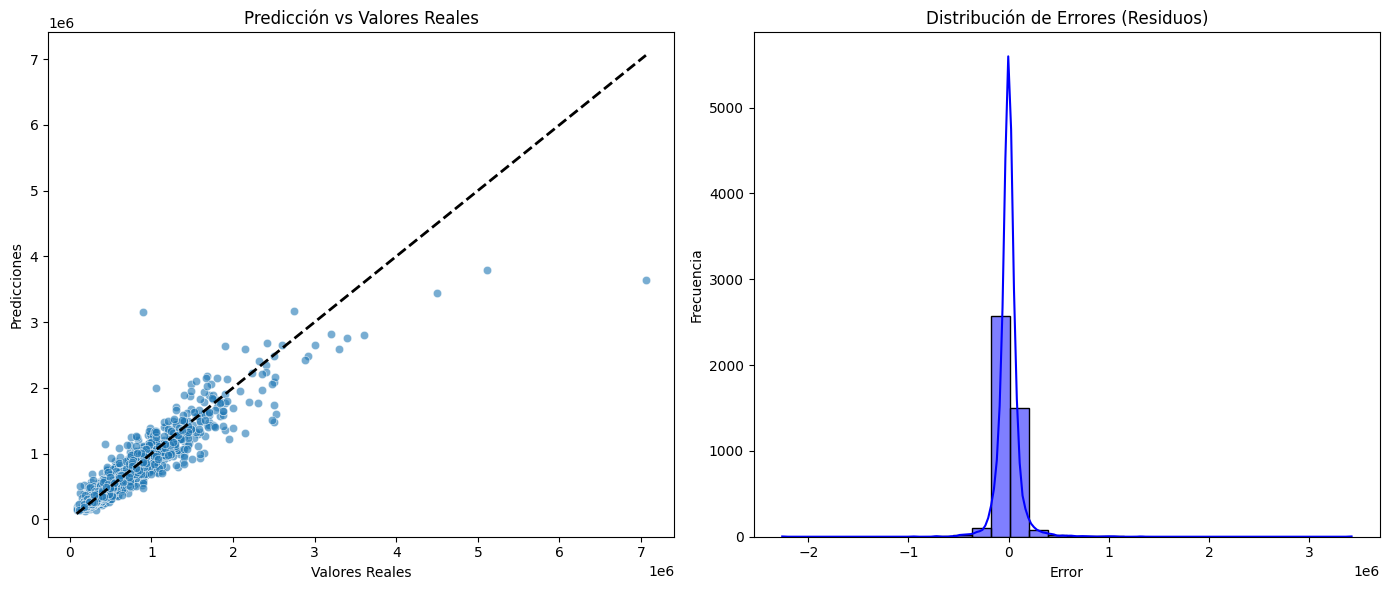

Error Cuadrático Medio (MSE): 15382761214.065
Raíz del Error Cuadrático Medio (RMSE): 124027.260
Error Absoluto Medio (MAE): 63648.207
R²: 0.882
R² Ajustado: 0.881


In [137]:
lgbm_regressor.fit(X_train_gbm_filtered, y_train)
y_train_pred = gbm_regressor.predict(X = X_train_gbm_filtered)
y_test_pred = gbm_regressor.predict(X = X_test_gbm_filtered)

resultados_regresion(y_train, y_train_pred, X = X_train_gbm_filtered)
resultados_regresion(y_test, y_test_pred, X = X_test_gbm_filtered)

#### Verifico los resultados con CV

In [138]:
# Evaluación de ambos modelos con caracteristicas reducidas

# Lista de modelos que queremos evaluar
models = [lgbm_regressor, gbm_regressor]

# Inicializar el DataFrame vacío donde se guardarán los resultados
results_df = pd.DataFrame()

# Función para evaluar los modelos y almacenar los resultados
for model in models:
    model_name = type(model).__name__  # Obtener el nombre del modelo

    # Evaluar el modelo en ambos conjuntos de datos
    for X_train_filtered_version, features_dropped in zip([X_train_lgbm_filtered, X_train_gbm_filtered], 
                                                           ['lgbm_features_to_drop', 'gbm_features_to_drop']):
        # Ajustar el modelo al conjunto de entrenamiento
        model.fit(X_train_filtered_version, y_train)
        
        # Evaluar el modelo usando la función 'model_evaluation'
        df, overfitting_risk = model_evaluation(model, X_train_filtered_version, y_train, metric=chosen_metric)

        # Extraer los resultados de la evaluación
        mean_train_score = df.loc['train_set', 'mean']
        std_train_score = df.loc['train_set', 'std']
        interval_lower_train = df.loc['train_set', 'interval_lower']
        interval_upper_train = df.loc['train_set', 'interval_upper']
        
        mean_test_score = df.loc['test_set', 'mean']
        std_test_score = df.loc['test_set', 'std']
        interval_lower_test = df.loc['test_set', 'interval_lower']
        interval_upper_test = df.loc['test_set', 'interval_upper']

        # Extraer el valor p (de riesgo de sobreajuste)
        p_value = overfitting_risk.get('p_value', 1.0)

        # Crear un diccionario con los resultados para agregar al DataFrame
        results = {
            "model": model_name,
            "features_dropped": features_dropped,
            "mean_train_score": mean_train_score,
            "std_train_score": std_train_score,
            "interval_lower_train": interval_lower_train,
            "interval_upper_train": interval_upper_train,
            "mean_test_score": mean_test_score,
            "std_test_score": std_test_score,
            "interval_lower_test": interval_lower_test,
            "interval_upper_test": interval_upper_test,
            "overfitting_risk": overfitting_risk['overfitting_likelihood'],
            "p_value": p_value
        }

        # Agregar los resultados al DataFrame de resultados
        results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)

# Mostrar los resultados finales
results_df

,model,features_dropped,mean_train_score,std_train_score,interval_lower_train,interval_upper_train,mean_test_score,std_test_score,interval_lower_test,interval_upper_test,overfitting_risk,p_value
0,LGBMRegressor,lgbm_features_to_drop,0.951729,0.001880,0.946089,0.957370,0.892492,0.014475,0.849066,0.935917,High,0.001087
1,LGBMRegressor,gbm_features_to_drop,0.951289,0.002450,0.943937,0.958640,0.891891,0.014205,0.849275,0.934507,High,0.000919
2,GradientBoostingRegressor,lgbm_features_to_drop,0.943216,0.002636,0.935308,0.951124,0.888450,0.017245,0.836715,0.940186,High,0.002816
3,GradientBoostingRegressor,gbm_features_to_drop,0.943727,0.002601,0.935922,0.951531,0.891071,0.018004,0.837059,0.945083,High,0.003897


## Selección del modelo
El modelo con mejor r2 es el de LGBMRegressor filtrando por las caracteristicas de la lista gbm_features_to_drop. Los valores de R2 se encuentran entre 0.849 y 0.934 donde para el conjunto de prueba fue de 0.883.

### Desempeño del modelo

In [139]:
def resultados_regresion_cv(model, X, y, cv=5):
    """
    Esta función evalúa el rendimiento de un modelo de regresión utilizando
    el error cuadrático medio (MSE), el error absoluto medio (MAE), el R²,
    el R² ajustado, el RMSE, el MAPE y el RMSPE, con validación cruzada (CV). 
    Devuelve un DataFrame con los resultados de las métricas, sus medias,
    desviaciones estándar y los intervalos de confianza al 95%.
    
    Parámetros:
    - model: el modelo de regresión a evaluar.
    - X: array-like, características del modelo (conjunto de entrenamiento).
    - y: array-like, valores verdaderos de las etiquetas (valores reales).
    - cv: número de pliegues para la validación cruzada (default es 5).
    
    Retorna:
    - df_resultados: DataFrame con las métricas y sus estadísticas.
    """
    
    # Asegurarse de que y sea un pandas Series con el mismo índice que X
    if isinstance(y, np.ndarray):
        y = pd.Series(y, index=X.index)  # Convertir y a pandas Series si es un array
    
    # Inicializar el objeto KFold para cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Listas para almacenar los resultados de cada pliegue
    mse_scores = []
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    r2_adj_scores = []
    mape_scores = []  # Lista para almacenar los MAPE
    rmspe_scores = []  # Lista para almacenar los RMSPE

    for train_idx, test_idx in kf.split(X):
        # Usar .iloc para indexar correctamente las filas
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir con el modelo
        y_pred = model.predict(X_test)
        
        # Calcular las métricas
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Calcular el R² ajustado
        n = len(y_test)
        p = X_test.shape[1]
        r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p else None
        
        # Calcular el MAPE (evitar división por cero)
        non_zero_idx = y_test != 0
        mape = np.mean(np.abs((y_test[non_zero_idx] - y_pred[non_zero_idx]) / y_test[non_zero_idx])) * 100 if np.any(non_zero_idx) else np.nan
        
        # Calcular el RMSPE (evitar división por cero)
        rmspe = np.sqrt(np.mean(np.square((y_test[non_zero_idx] - y_pred[non_zero_idx]) / y_test[non_zero_idx]))) * 100 if np.any(non_zero_idx) else np.nan
        
        # Guardar las métricas de este pliegue
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        if r2_adj is not None:
            r2_adj_scores.append(r2_adj)
        mape_scores.append(mape)
        rmspe_scores.append(rmspe)
    
    # Calcular las medias y desviaciones estándar
    mse_mean = np.mean(mse_scores)
    mse_std = np.std(mse_scores)
    rmse_mean = np.mean(rmse_scores)
    rmse_std = np.std(rmse_scores)
    mae_mean = np.mean(mae_scores)
    mae_std = np.std(mae_scores)
    r2_mean = np.mean(r2_scores)
    r2_std = np.std(r2_scores)
    r2_adj_mean = np.mean(r2_adj_scores) if r2_adj_scores else None
    r2_adj_std = np.std(r2_adj_scores) if r2_adj_scores else None
    mape_mean = np.mean(mape_scores)
    mape_std = np.std(mape_scores)
    rmspe_mean = np.mean(rmspe_scores)
    rmspe_std = np.std(rmspe_scores)

    # Calcular intervalos de confianza al 95% (usando una distribución t-student)
    ci_mse = stats.t.interval(0.95, len(mse_scores)-1, loc=mse_mean, scale=mse_std/np.sqrt(len(mse_scores)))
    ci_rmse = stats.t.interval(0.95, len(rmse_scores)-1, loc=rmse_mean, scale=rmse_std/np.sqrt(len(rmse_scores)))
    ci_mae = stats.t.interval(0.95, len(mae_scores)-1, loc=mae_mean, scale=mae_std/np.sqrt(len(mae_scores)))
    ci_r2 = stats.t.interval(0.95, len(r2_scores)-1, loc=r2_mean, scale=r2_std/np.sqrt(len(r2_scores)))
    ci_r2_adj = (None, None)
    if r2_adj_mean is not None:
        ci_r2_adj = stats.t.interval(0.95, len(r2_adj_scores)-1, loc=r2_adj_mean, scale=r2_adj_std/np.sqrt(len(r2_adj_scores)))
    ci_mape = stats.t.interval(0.95, len(mape_scores)-1, loc=mape_mean, scale=mape_std/np.sqrt(len(mape_scores)))
    ci_rmspe = stats.t.interval(0.95, len(rmspe_scores)-1, loc=rmspe_mean, scale=rmspe_std/np.sqrt(len(rmspe_scores)))
    
    # Crear el DataFrame de resultados
    df_resultados = pd.DataFrame({
        "Metric": ["MSE", "RMSE", "MAE", "R²", "R² Ajustado", "MAPE", "RMSPE"],
        "Mean": [mse_mean, rmse_mean, mae_mean, r2_mean, r2_adj_mean, mape_mean, rmspe_mean],
        "Std": [mse_std, rmse_std, mae_std, r2_std, r2_adj_std, mape_std, rmspe_std],
        "Confidence Interval Lower": [ci_mse[0], ci_rmse[0], ci_mae[0], ci_r2[0], ci_r2_adj[0], ci_mape[0], ci_rmspe[0]],
        "Confidence Interval Upper": [ci_mse[1], ci_rmse[1], ci_mae[1], ci_r2[1], ci_r2_adj[1], ci_mape[1], ci_rmspe[1]]
    })
    
    return df_resultados

In [140]:
df_resultados = resultados_regresion_cv(lgbm_regressor, X_train_gbm_filtered, y_train)
df_resultados

,Metric,Mean,Std,Confidence Interval Lower,Confidence Interval Upper
0,MSE,1.472602e+10,2.903103e+09,1.112134e+10,1.833070e+10
1,RMSE,1.207808e+05,1.174800e+04,1.061937e+05,1.353679e+05
2,MAE,6.460088e+04,1.528839e+03,6.270257e+04,6.649918e+04
3,R²,8.918912e-01,1.420533e-02,8.742530e-01,9.095295e-01
4,R² Ajustado,8.914197e-01,1.426730e-02,8.737045e-01,9.091349e-01
5,MAPE,1.215347e+01,1.619761e-01,1.195235e+01,1.235459e+01
6,RMSPE,1.840610e+01,5.368250e-01,1.773955e+01,1.907266e+01


- MAE (Error Absoluto Medio) se encuentra en el intervalo [62,703, 66,499], lo que significa que, en promedio, las predicciones del modelo, sin penalizar los valores extremos, están equivocadas entre 62,703 y 66,499 unidades. Este valor nos da una idea del error promedio absoluto entre las predicciones y los valores reales, es decir, cuán lejos están las predicciones del modelo de los valores reales, en unidades del objetivo.
- MAPE (Error Porcentual Absoluto Medio) se encuentra en el intervalo [11.95%, 12.35%], lo que significa que, en promedio, las predicciones del modelo están equivocadas entre el 11.95% y el 12.35%. 
- RMSE (Raíz del Error Cuadrático Medio) se encuentra en el intervalo [106,193, 135,368], lo que significa que, en promedio, las predicciones del modelo, penalizando los valores extremos, están equivocadas entre 106,193 y 135,368 unidades. El RMSE da mayor peso a los errores grandes, lo que implica que si el modelo tiene grandes predicciones erróneas, estas influirán más en esta métrica que en el MAE.
- RMSPE (Error Cuadrático Porcentual Raíz) se encuentra en el intervalo [17.74%, 19.07%], lo que significa que, en promedio, las predicciones del modelo, penalizando los errores porcentuales extremos, están equivocadas entre el 17.74% y el 19.07%. 
- R² se encuentra en el intervalo [0.874, 0.909], lo que indica que aproximadamente el 88% de la variabilidad de los datos es explicada por el modelo. Esto es muy bueno, ya que significa que el modelo hace un buen trabajo al capturar la relación entre las variables predictoras y las etiquetas reales. Es decir, el modelo tiene una capacidad de predicción alta para los datos en cuestión.
- R² Ajustado se encuentra en el intervalo [0.873, 0.909], que es muy similar al R², lo que sugiere que las variables utilizadas en el modelo están haciendo una contribución significativa. El R² Ajustado es útil porque penaliza los modelos con muchas variables predictoras que no están aportando información significativa, lo que hace que esta métrica sea más confiable cuando se comparan modelos con diferentes números de variables.

Debemos tener en cuenta la mayoria de los errores que presenta el modelo es debido a las casas con precios de ventas muy elevados

In [141]:
filter_selected_features = DropFeatures(features_to_drop=gbm_features_to_drop)

## Pipeline para preprocesmiento de datos

In [142]:
preproceser_pipeline = Pipeline([
    ('convert_to_datetime', convert_to_datetime_transformer),
    ('agregar_venta_num', agregar_venta_num_transformer),
    ('elapsed_years', elapsed_years_transformer),
    ('renovated', renovated_transformer),
    ('time_since_renovation', time_since_renovation_transformer),
    ('basemente', basement_transformer),
    ('zipcode_mapping', zipcode_mapper),
    ('drop_features', drop_features_transformer),  
    ('custom_scaler', CustomScalerWithColumnGroups(columns_to_scale=columns_to_scale)),
    ('selected_features', filter_selected_features)
])

### Verifico que el pipeline funciones correctamente

In [143]:
raw_data = pd.read_csv('../House Prices/Datasets/houseprice.csv')
df_raw = raw_data.copy()
X_raw = df_raw.drop(columns = "price")
y_raw = df_raw.loc[:, ['price']]
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size = 0.2, random_state = 42)
X_train_raw.shape, X_test_raw.shape

((17277, 20), (4320, 20))

#### Verifico si el conjunto de datos se dividó de la misma manera que el preprocesado

In [144]:
are_equal = y_train_raw.equals(y_train_filtered)
print("\n¿Son iguales los DataFrames?", are_equal)


¿Son iguales los DataFrames? True


#### Verifico paso a paso las transformaciones del pipeline en un conjunto muestra

In [145]:
X_sample = X_train_raw.copy()
prueba_data = X_sample.sample(50)

In [146]:
for nombre, paso in preproceser_pipeline.steps:
    prueba_data = paso.fit_transform(prueba_data)
    print(f"\nDespués de {nombre}:\n",prueba_data.head(10))


Después de convert_to_datetime:
                id       date  bedrooms  bathrooms  sqft_living  sqft_lot  \
4553   3546000490 2014-10-07         3       1.75         2060      7251   
15601  7129302555 2014-10-03         2       1.00         1410      5650   
12141  4036801070 2014-08-04         4       1.50         1280      7400   
3780   9521100855 2014-06-10         3       1.50         1290      1286   
19827  7853321180 2014-12-22         5       2.50         2550      6405   
3186   3524039209 2014-05-06         4       2.75         3370      8103   
4872    446000190 2014-12-08         5       3.25         2450      6534   
7413    626049091 2014-06-27         2       1.00          720     11400   
7555   4077800412 2015-03-16         3       1.50         1730      9509   
18692  7100000110 2015-01-14         3       1.00         1580      8308   

       floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
4553      1.0           0     0          3      7

#### Verifico paso a paso los tipos de datos al aplicar las transformaciones del pipeline en un conjunto muestra

In [147]:
X_sample = X_train_raw.copy()
prueba_data = X_sample.sample(50)

In [148]:
for nombre, paso in preproceser_pipeline.steps:
    prueba_data = paso.fit_transform(prueba_data)
    print(f"\nDespués de {nombre}:\n",prueba_data.dtypes)


Después de convert_to_datetime:
 id                        int64
date             datetime64[ns]
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

Después de agregar_venta_num:
 id                        int64
date             datetime64[ns]
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                    

#### Verfico que el pipiline no genere valores nulos

In [149]:
X_sample = X_train_raw.copy()
prueba_data = X_sample.sample(50)

In [150]:
for nombre, paso in preproceser_pipeline.steps:
    prueba_data = paso.fit_transform(prueba_data)
    # Filtrar y mostrar solo las columnas con nulos
    nulos = prueba_data.isnull().sum()
    nulos_con_datos = nulos[nulos > 0]  # Solo columnas con nulos
    print(f"\nNulos después de {nombre}:\n",nulos_con_datos)


Nulos después de convert_to_datetime:
 Series([], dtype: int64)

Nulos después de agregar_venta_num:
 Series([], dtype: int64)

Nulos después de elapsed_years:
 Series([], dtype: int64)

Nulos después de renovated:
 Series([], dtype: int64)

Nulos después de time_since_renovation:
 Series([], dtype: int64)

Nulos después de basemente:
 Series([], dtype: int64)

Nulos después de zipcode_mapping:
 Series([], dtype: int64)

Nulos después de drop_features:
 Series([], dtype: int64)

Nulos después de custom_scaler:
 Series([], dtype: int64)

Nulos después de selected_features:
 Series([], dtype: int64)


#### Verifico que queden las mismas columnas

In [151]:
prueba_data = prueba_data[sorted(prueba_data.columns)]
X_train_gbm_filtered = X_train_gbm_filtered[sorted(X_train_gbm_filtered.columns)]

In [152]:
are_equal = prueba_data.columns.equals(X_train_gbm_filtered.columns)
print("\n¿Los dataframes tienen las mismas caracteristicas?", are_equal)


¿Los dataframes tienen las mismas caracteristicas? True


#### Verifico que los datos de los dataframes sean iguales

In [153]:
X_train_pipe = preproceser_pipeline.fit_transform(X_train_raw)

In [154]:
X_train_pipe = X_train_pipe[sorted(X_train_pipe.columns)]
X_train_gbm_filtered = X_train_gbm_filtered[sorted(X_train_gbm_filtered.columns)]

In [155]:
are_equal = X_train_pipe.equals(X_train_gbm_filtered)
print("\n¿Los dataframes son iguales?", are_equal)


¿Los dataframes son iguales? True


In [156]:
# Ver diferencias columna por columna
if not are_equal:
    for column in X_train_pipe.columns:
        if not X_train_pipe[column].equals(X_train_gbm_filtered[column]):
            print(f"Diferencias en la columna: {column}")
            print("Valores en X_train_pipe:")
            print(X_train_pipe[column].unique())
            print("Valores en X_train:")
            print(X_train_gbm_filtered[column].unique())

### Pipeline final

In [157]:
house_price_pipeline = Pipeline([
    ('convert_to_datetime', convert_to_datetime_transformer),
    ('agregar_venta_num', agregar_venta_num_transformer),
    ('elapsed_years', elapsed_years_transformer),
    ('renovated', renovated_transformer),
    ('time_since_renovation', time_since_renovation_transformer),
    ('basemente', basement_transformer),
    ('zipcode_mapping', zipcode_mapper),
    ('drop_features', drop_features_transformer),  
    ('custom_scaler', CustomScalerWithColumnGroups(columns_to_scale=columns_to_scale)),
    ('selected_features', filter_selected_features),
    ('model', lgbm_regressor)
])

In [158]:
# Entrenar el pipeline completo
house_price_pipeline.fit(X_train_raw, y_train_raw)

Pipeline(steps=[('convert_to_datetime',
                 FunctionTransformer(func=<function convert_to_datetime at 0x0000021165A934C0>,
                                     kw_args={'column_names': ['date']})),
                ('agregar_venta_num',
                 FunctionTransformer(func=<function agregar_venta_num at 0x0000021165A9D820>)),
                ('elapsed_years',
                 FunctionTransformer(func=<function elapsed_years at 0x0000021165AA9940>,
                                     kw_args={'var': 'da...
                                                'floors', 'sqft_basement',
                                                'sqft_lot15', 'no_basement'])),
                ('model',
                 LGBMRegressor(colsample_bytree=0.5767378933010041,
                               learning_rate=0.03696238742158522, max_depth=10,
                               min_child_samples=43,
                               min_child_weight=0.000957613588615844,
                               n_estimators=615, num_leaves=90, random_state=42,
                               reg_alpha=0.6890131590749506,
                               reg_lambda=0.40278083720796354,
                               subsample=0.7891205647616174, verbosity=-1))])

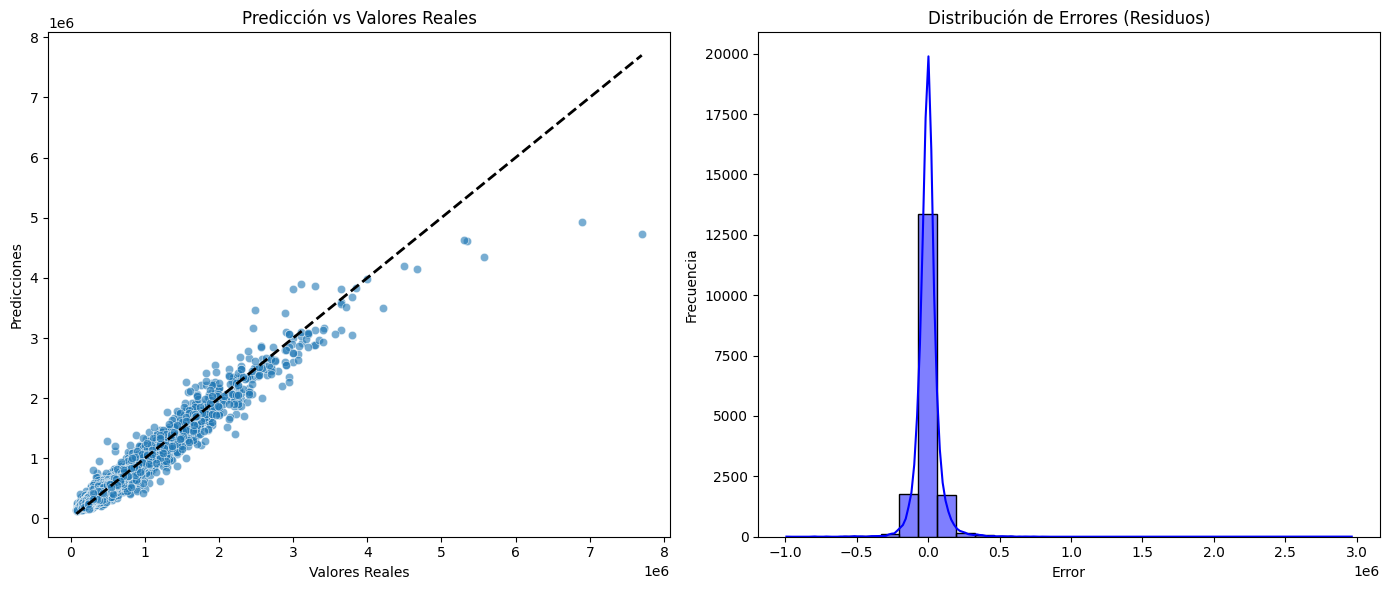

Error Cuadrático Medio (MSE): 6513044900.186
Raíz del Error Cuadrático Medio (RMSE): 80703.438
Error Absoluto Medio (MAE): 48467.676
R²: 0.952
R² Ajustado: 0.952


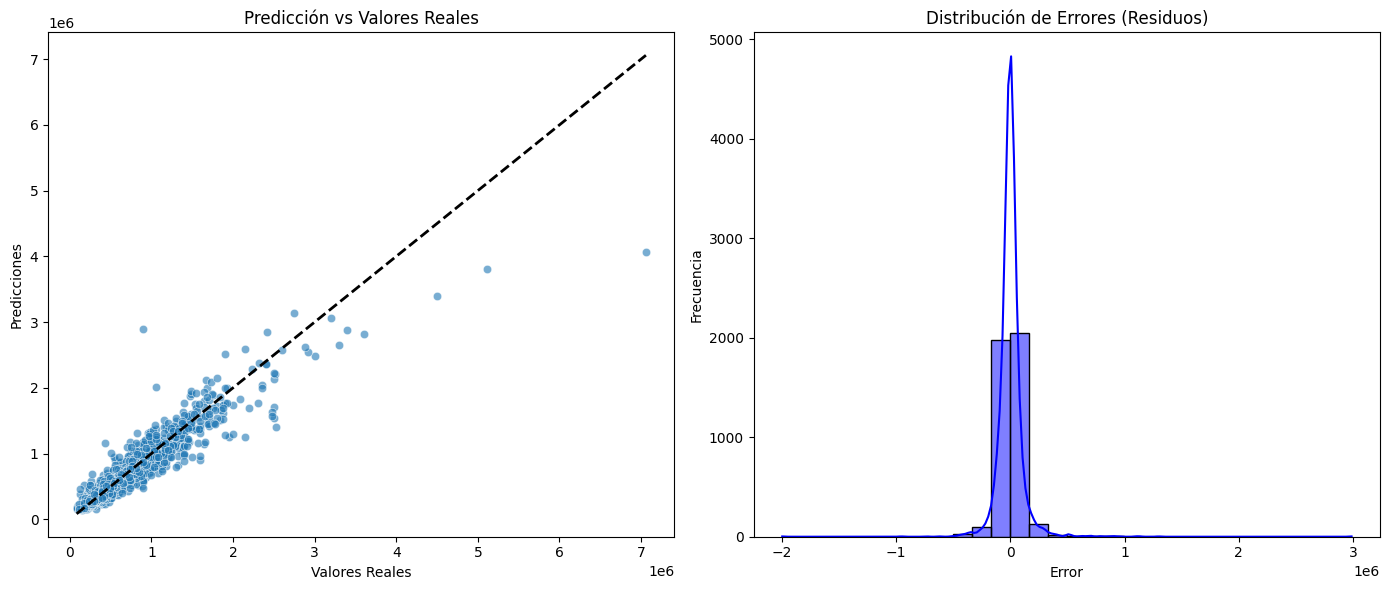

Error Cuadrático Medio (MSE): 14133088341.630
Raíz del Error Cuadrático Medio (RMSE): 118882.666
Error Absoluto Medio (MAE): 62952.006
R²: 0.891
R² Ajustado: 0.891


In [159]:
y_train_pred = house_price_pipeline.predict(X = X_train_raw)
y_test_pred = house_price_pipeline.predict(X = X_test_raw)

resultados_regresion(y_train, y_train_pred, X = X_train_raw)
resultados_regresion(y_test, y_test_pred, X = X_test_raw)

## Guardado del modelo final

In [160]:
import joblib

In [161]:
joblib.dump(house_price_pipeline, 'house_price_pipeline_model.joblib')

['house_price_pipeline_model.joblib']

### Cargar el modelo y verificar su funcionamiento

In [163]:
loaded_model = joblib.load('house_price_pipeline_model.joblib')

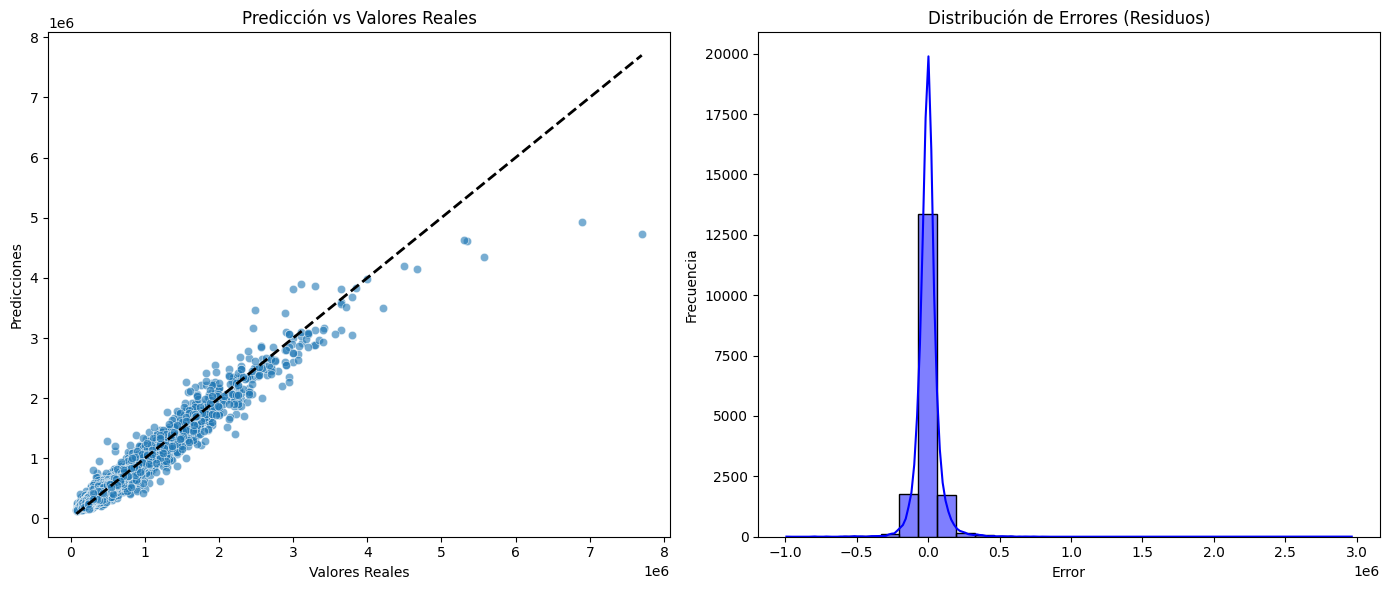

Error Cuadrático Medio (MSE): 6513044900.186
Raíz del Error Cuadrático Medio (RMSE): 80703.438
Error Absoluto Medio (MAE): 48467.676
R²: 0.952
R² Ajustado: 0.952


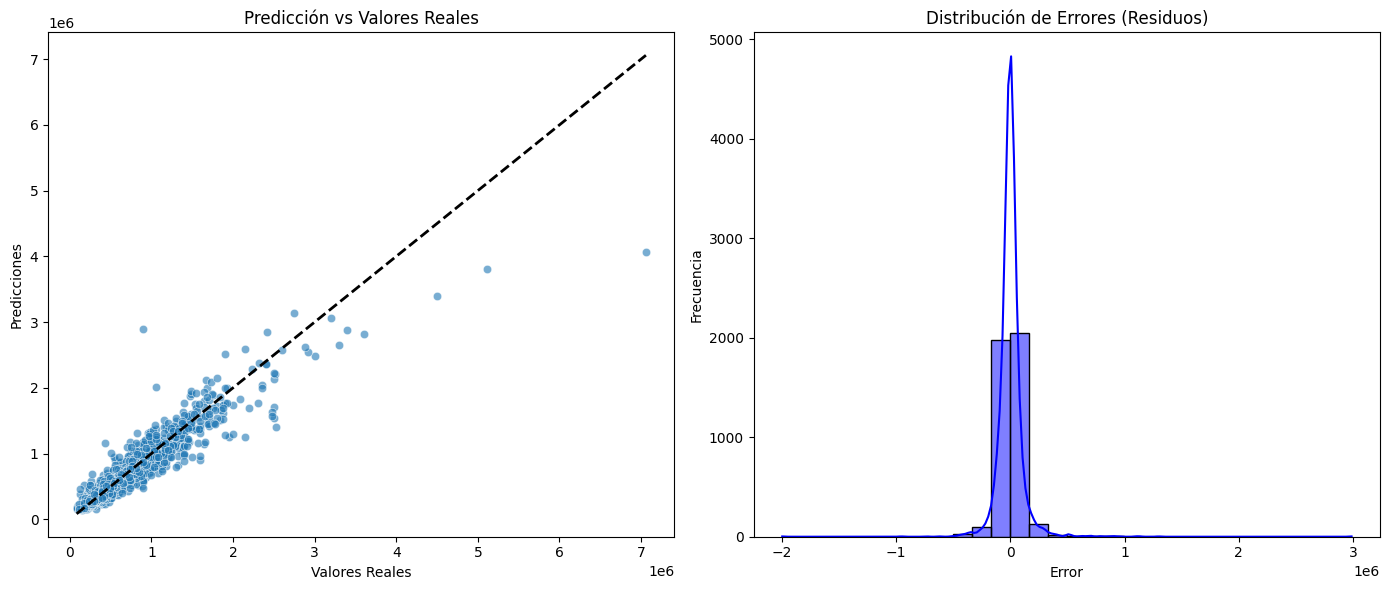

Error Cuadrático Medio (MSE): 14133088341.630
Raíz del Error Cuadrático Medio (RMSE): 118882.666
Error Absoluto Medio (MAE): 62952.006
R²: 0.891
R² Ajustado: 0.891


In [164]:
y_train_pred = loaded_model.predict(X = X_train_raw)
y_test_pred = loaded_model.predict(X = X_test_raw)

resultados_regresion(y_train, y_train_pred, X = X_train_raw)
resultados_regresion(y_test, y_test_pred, X = X_test_raw)